<a href="https://colab.research.google.com/github/ahdi3/DeepLearningTask3/blob/main/TaskWeek4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama: Ahdi Nazzalul Ahsan

NPM: 2206812956

# **Modern Convolutional Neural Networks**

In [ ]:
!pip install d2l==1.0.3


#8.1 Deep Convolutional Neural Networks (AlexNet)
:label:`sec_alexnet`


Although CNNs were well known
in the computer vision and machine learning communities
following the introduction of LeNet :cite:`LeCun.Jackel.Bottou.ea.1995`,
they did not immediately dominate the field.
Although LeNet achieved good results on early small datasets,
the performance and feasibility of training CNNs
on larger, more realistic datasets had yet to be established.
In fact, for much of the intervening time between the early 1990s
and the watershed results of 2012 :cite:`Krizhevsky.Sutskever.Hinton.2012`,
neural networks were often surpassed by other machine learning methods,
such as kernel methods :cite:`Scholkopf.Smola.2002`, ensemble methods :cite:`Freund.Schapire.ea.1996`,
and structured estimation :cite:`Taskar.Guestrin.Koller.2004`.

For computer vision, this comparison is perhaps not entirely accurate.
That is, although the inputs to convolutional networks
consist of raw or lightly-processed (e.g., by centering) pixel values, practitioners would never feed raw pixels into traditional models.
Instead, typical computer vision pipelines
consisted of manually engineering feature extraction pipelines, such as SIFT :cite:`Lowe.2004`, SURF :cite:`Bay.Tuytelaars.Van-Gool.2006`, and bags of visual words :cite:`Sivic.Zisserman.2003`.
Rather than *learning* the features, the features were *crafted*.
Most of the progress came from having more clever ideas for feature extraction on the one hand and deep insight into geometry :cite:`Hartley.Zisserman.2000` on the other. The learning algorithm was often considered an afterthought.

Although some neural network accelerators were available in the 1990s,
they were not yet sufficiently powerful to make
deep multichannel, multilayer CNNs
with a large number of parameters. For instance, NVIDIA's GeForce 256 from 1999
was able to process at most 480 million floating-point operations, such as additions and multiplications, per second (MFLOPS), without any meaningful
programming framework for operations beyond games. Today's accelerators are able to perform in excess of 1000 TFLOPs per device.
Moreover, datasets were still relatively small: OCR on 60,000 low-resolution $28 \times 28$ pixel images was considered a highly challenging task.
Added to these obstacles, key tricks for training neural networks
including parameter initialization heuristics :cite:`Glorot.Bengio.2010`,
clever variants of stochastic gradient descent :cite:`Kingma.Ba.2014`,
non-squashing activation functions :cite:`Nair.Hinton.2010`,
and effective regularization techniques :cite:`Srivastava.Hinton.Krizhevsky.ea.2014` were still missing.

Thus, rather than training *end-to-end* (pixel to classification) systems,
classical pipelines looked more like this:

1. Obtain an interesting dataset. In the early days, these datasets required expensive sensors. For instance, the [Apple QuickTake 100](https://en.wikipedia.org/wiki/Apple_QuickTake) of 1994 sported a whopping 0.3 megapixel (VGA) resolution, capable of storing up to 8 images, all for the price of \$1000.
1. Preprocess the dataset with hand-crafted features based on some knowledge of optics, geometry, other analytic tools, and occasionally on the serendipitous discoveries by lucky graduate students.
1. Feed the data through a standard set of feature extractors such as the SIFT (scale-invariant feature transform) :cite:`Lowe.2004`, the SURF (speeded up robust features) :cite:`Bay.Tuytelaars.Van-Gool.2006`, or any number of other hand-tuned pipelines. OpenCV still provides SIFT extractors to this day!
1. Dump the resulting representations into your favorite classifier, likely a linear model or kernel method, to train a classifier.

If you spoke to machine learning researchers,
they would reply that machine learning was both important and beautiful.
Elegant theories proved the properties of various classifiers :cite:`boucheron2005theory` and convex
optimization :cite:`Boyd.Vandenberghe.2004` had become the mainstay for obtaining them.
The field of machine learning was thriving, rigorous, and eminently useful. However,
if you spoke to a computer vision researcher,
you would hear a very different story.
The dirty truth of image recognition, they would tell you,
is that features, geometry :cite:`Hartley.Zisserman.2000,hartley2009global`, and engineering,
rather than novel learning algorithms, drove progress.
Computer vision researchers justifiably believed
that a slightly bigger or cleaner dataset
or a slightly improved feature-extraction pipeline
mattered far more to the final accuracy than any learning algorithm.


In [ ]:

import torch
from torch import nn
from d2l import torch as d2l

## Representation Learning

Another way to cast the state of affairs is that
the most important part of the pipeline was the representation.
And up until 2012 the representation was calculated mostly mechanically.
In fact, engineering a new set of feature functions, improving results, and writing up the method
all featured prominently in papers.
SIFT :cite:`Lowe.2004`,
SURF :cite:`Bay.Tuytelaars.Van-Gool.2006`,
HOG (histograms of oriented gradient) :cite:`Dalal.Triggs.2005`,
bags of visual words :cite:`Sivic.Zisserman.2003`,
and similar feature extractors ruled the roost.

Another group of researchers,
including Yann LeCun, Geoff Hinton, Yoshua Bengio,
Andrew Ng, Shun-ichi Amari, and Juergen Schmidhuber,
had different plans.
They believed that features themselves ought to be learned.
Moreover, they believed that to be reasonably complex,
the features ought to be hierarchically composed
with multiple jointly learned layers, each with learnable parameters.
In the case of an image, the lowest layers might come
to detect edges, colors, and textures, by analogy with how the visual system in animals
processes its input. In particular, the automatic design of visual features such as those obtained
by sparse coding :cite:`olshausen1996emergence` remained an open challenge until the advent of modern CNNs.
It was not until :citet:`Dean.Corrado.Monga.ea.2012,le2013building` that the idea of generating features
from image data automatically gained significant traction.

The first modern CNN :cite:`Krizhevsky.Sutskever.Hinton.2012`, named
*AlexNet* after one of its inventors, Alex Krizhevsky, is largely an evolutionary improvement
over LeNet. It achieved excellent performance in the 2012 ImageNet challenge.

![Image filters learned by the first layer of AlexNet. Reproduction courtesy of :citet:`Krizhevsky.Sutskever.Hinton.2012`.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/filters.png?raw=1)
:width:`400px`
:label:`fig_filters`

Interestingly, in the lowest layers of the network,
the model learned feature extractors that resembled some traditional filters.
:numref:`fig_filters`
shows lower-level image descriptors.
Higher layers in the network might build upon these representations
to represent larger structures, like eyes, noses, blades of grass, and so on.
Even higher layers might represent whole objects
like people, airplanes, dogs, or frisbees.
Ultimately, the final hidden state learns a compact representation
of the image that summarizes its contents
such that data belonging to different categories can be easily separated.

AlexNet (2012) and its precursor LeNet (1995) share many architectural elements. This begs the question: why did it take so long?
A key difference was that, over the previous two decades, the amount of data and the computing power available had increased significantly. As such AlexNet was much larger: it was trained on much more data, and on much faster GPUs compared to the CPUs available in 1995.

### Missing Ingredient: Data

Deep models with many layers require large amounts of data
in order to enter the regime
where they significantly outperform traditional methods
based on convex optimizations (e.g., linear and kernel methods).
However, given the limited storage capacity of computers,
the relative expense of (imaging) sensors,
and the comparatively tighter research budgets in the 1990s,
most research relied on tiny datasets.
Numerous papers relied on the UCI collection of datasets,
many of which contained only hundreds or (a few) thousands of images
captured in low resolution and often with an artificially clean background.

In 2009, the ImageNet dataset was released :cite:`Deng.Dong.Socher.ea.2009`,
challenging researchers to learn models from 1 million examples,
1000 each from 1000 distinct categories of objects. The categories themselves
were based on the most popular noun nodes in WordNet :cite:`Miller.1995`.
The ImageNet team used Google Image Search to prefilter large candidate sets
for each category and employed
the Amazon Mechanical Turk crowdsourcing pipeline
to confirm for each image whether it belonged to the associated category.
This scale was unprecedented, exceeding others by over an order of magnitude
(e.g., CIFAR-100 has 60,000 images). Another aspect was that the images were at
relatively high resolution of $224 \times 224$ pixels, unlike the 80 million-sized
TinyImages dataset :cite:`Torralba.Fergus.Freeman.2008`, consisting of $32 \times 32$ pixel thumbnails.
This allowed for the formation of higher-level features.
The associated competition, dubbed the ImageNet Large Scale Visual Recognition
Challenge :cite:`russakovsky2015imagenet`,
pushed computer vision and machine learning research forward,
challenging researchers to identify which models performed best
at a greater scale than academics had previously considered. The largest vision datasets, such as LAION-5B
:cite:`schuhmann2022laion` contain billions of images with additional metadata.

### Missing Ingredient: Hardware

Deep learning models are voracious consumers of compute cycles.
Training can take hundreds of epochs, and each iteration
requires passing data through many layers of computationally expensive
linear algebra operations.
This is one of the main reasons why in the 1990s and early 2000s,
simple algorithms based on the more-efficiently optimized
convex objectives were preferred.

*Graphical processing units* (GPUs) proved to be a game changer
in making deep learning feasible.
These chips had earlier been developed for accelerating
graphics processing to benefit computer games.
In particular, they were optimized for high throughput $4 \times 4$
matrix--vector products, which are needed for many computer graphics tasks.
Fortunately, the math is strikingly similar
to that required for calculating convolutional layers.
Around that time, NVIDIA and ATI had begun optimizing GPUs
for general computing operations :cite:`Fernando.2004`,
going as far as to market them as *general-purpose GPUs* (GPGPUs).

To provide some intuition, consider the cores of a modern microprocessor
(CPU).
Each of the cores is fairly powerful running at a high clock frequency
and sporting large caches (up to several megabytes of L3).
Each core is well-suited to executing a wide range of instructions,
with branch predictors, a deep pipeline, specialized execution units,
speculative execution,
and many other bells and whistles
that enable it to run a large variety of programs with sophisticated control flow.
This apparent strength, however, is also its Achilles heel:
general-purpose cores are very expensive to build. They excel at general-purpose
code with lots of control flow.
This requires lots of chip area, not just for the
actual ALU (arithmetic logical unit) where computation happens, but also for
all the aforementioned bells and whistles, plus
memory interfaces, caching logic between cores,
high-speed interconnects, and so on. CPUs are
comparatively bad at any single task when compared with dedicated hardware.
Modern laptops have 4--8 cores,
and even high-end servers rarely exceed 64 cores per socket,
simply because it is not cost-effective.

By comparison, GPUs can consist of thousands of small processing elements (NIVIDA's latest Ampere chips have up to 6912 CUDA cores), often grouped into larger groups (NVIDIA calls them warps).
The details differ somewhat between NVIDIA, AMD, ARM and other chip vendors. While each core is relatively weak,
running at about 1GHz clock frequency,
it is the total number of such cores that makes GPUs orders of magnitude faster than CPUs.
For instance, NVIDIA's recent Ampere A100 GPU offers over 300 TFLOPs per chip for specialized 16-bit precision (BFLOAT16) matrix-matrix multiplications, and up to 20 TFLOPs for more general-purpose floating point operations (FP32).
At the same time, floating point performance of CPUs rarely exceeds 1 TFLOPs. For instance, Amazon's Graviton 3  reaches 2 TFLOPs peak performance for 16-bit precision operations, a number similar to the GPU performance of Apple's M1 processor.

There are many reasons why GPUs are much faster than CPUs in terms of FLOPs.
First, power consumption tends to grow *quadratically* with clock frequency.
Hence, for the power budget of a CPU core that runs four times faster (a typical number),
you can use 16 GPU cores at $\frac{1}{4}$ the speed,
which yields $16 \times \frac{1}{4} = 4$ times the performance.
Second, GPU cores are much simpler
(in fact, for a long time they were not even *able*
to execute general-purpose code),
which makes them more energy efficient. For instance, (i) they tend not to support speculative evaluation, (ii) it typically is not possible to program each processing element individually, and (iii) the caches per core tend to be much smaller.
Last, many operations in deep learning require high memory bandwidth.
Again, GPUs shine here with buses that are at least 10 times as wide as many CPUs.

Back to 2012. A major breakthrough came
when Alex Krizhevsky and Ilya Sutskever
implemented a deep CNN
that could run on GPUs.
They realized that the computational bottlenecks in CNNs,
convolutions and matrix multiplications,
are all operations that could be parallelized in hardware.
Using two NVIDIA GTX 580s with 3GB of memory, either of which was capable of 1.5 TFLOPs (still a challenge for most CPUs a decade later),
they implemented fast convolutions.
The [cuda-convnet](https://code.google.com/archive/p/cuda-convnet/) code
was good enough that for several years
it was the industry standard and powered
the first couple of years of the deep learning boom.

## AlexNet

AlexNet, which employed an 8-layer CNN,
won the ImageNet Large Scale Visual Recognition Challenge 2012
by a large margin :cite:`Russakovsky.Deng.Huang.ea.2013`.
This network showed, for the first time,
that the features obtained by learning can transcend manually-designed features, breaking the previous paradigm in computer vision.

The architectures of AlexNet and LeNet are strikingly similar,
as :numref:`fig_alexnet` illustrates.
Note that we provide a slightly streamlined version of AlexNet
removing some of the design quirks that were needed in 2012
to make the model fit on two small GPUs.

![From LeNet (left) to AlexNet (right).](http://d2l.ai/_images/alexnet.svg)
:label:`fig_alexnet`

There are also significant differences between AlexNet and LeNet.
First, AlexNet is much deeper than the comparatively small LeNet-5.
AlexNet consists of eight layers: five convolutional layers,
two fully connected hidden layers, and one fully connected output layer.
Second, AlexNet used the ReLU instead of the sigmoid
as its activation function. Let's delve into the details below.

### Architecture

In AlexNet's first layer, the convolution window shape is $11\times11$.
Since the images in ImageNet are eight times taller and wider
than the MNIST images,
objects in ImageNet data tend to occupy more pixels with more visual detail.
Consequently, a larger convolution window is needed to capture the object.
The convolution window shape in the second layer
is reduced to $5\times5$, followed by $3\times3$.
In addition, after the first, second, and fifth convolutional layers,
the network adds max-pooling layers
with a window shape of $3\times3$ and a stride of 2.
Moreover, AlexNet has ten times more convolution channels than LeNet.

After the final convolutional layer, there are two huge fully connected layers
with 4096 outputs.
These layers require nearly 1GB model parameters.
Because of the limited memory in early GPUs,
the original AlexNet used a dual data stream design,
so that each of their two GPUs could be responsible
for storing and computing only its half of the model.
Fortunately, GPU memory is comparatively abundant now,
so we rarely need to break up models across GPUs these days
(our version of the AlexNet model deviates
from the original paper in this aspect).

### Activation Functions

Furthermore, AlexNet changed the sigmoid activation function to a simpler ReLU activation function. On the one hand, the computation of the ReLU activation function is simpler. For example, it does not have the exponentiation operation found in the sigmoid activation function.
 On the other hand, the ReLU activation function makes model training easier when using different parameter initialization methods. This is because, when the output of the sigmoid activation function is very close to 0 or 1, the gradient of these regions is almost 0, so that backpropagation cannot continue to update some of the model parameters. By contrast, the gradient of the ReLU activation function in the positive interval is always 1 (:numref:`subsec_activation-functions`). Therefore, if the model parameters are not properly initialized, the sigmoid function may obtain a gradient of almost 0 in the positive interval, meaning that the model cannot be effectively trained.

### Capacity Control and Preprocessing

AlexNet controls the model complexity of the fully connected layer
by dropout (:numref:`sec_dropout`),
while LeNet only uses weight decay.
To augment the data even further, the training loop of AlexNet
added a great deal of image augmentation,
such as flipping, clipping, and color changes.
This makes the model more robust and the larger sample size effectively reduces overfitting.
See :citet:`Buslaev.Iglovikov.Khvedchenya.ea.2020` for an in-depth review of such preprocessing steps.


In [ ]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

We [**construct a single-channel data example**] with both height and width of 224 (**to observe the output shape of each layer**). It matches the AlexNet architecture in :numref:`fig_alexnet`.


In [ ]:
AlexNet().layer_summary((1, 1, 224, 224))

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

## Training

Although AlexNet was trained on ImageNet in :citet:`Krizhevsky.Sutskever.Hinton.2012`,
we use Fashion-MNIST here
since training an ImageNet model to convergence could take hours or days
even on a modern GPU.
One of the problems with applying AlexNet directly on [**Fashion-MNIST**]
is that its (**images have lower resolution**) ($28 \times 28$ pixels)
(**than ImageNet images.**)
To make things work, (**we upsample them to $224 \times 224$**).
This is generally not a smart practice, as it simply increases the computational
complexity without adding information. Nonetheless, we do it here to be faithful to the AlexNet architecture.
We perform this resizing with the `resize` argument in the `d2l.FashionMNIST` constructor.

Now, we can [**start training AlexNet.**]
Compared to LeNet in :numref:`sec_lenet`,
the main change here is the use of a smaller learning rate
and much slower training due to the deeper and wider network,
the higher image resolution, and the more costly convolutions.


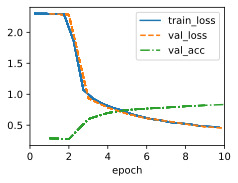

In [ ]:
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)

## Discussion

AlexNet's structure bears a striking resemblance to LeNet, with a number of critical improvements, both for accuracy (dropout) and for ease of training (ReLU). What is equally striking is the amount of progress that has been made in terms of deep learning tooling. What was several months of work in 2012 can now be accomplished in a dozen lines of code using any modern framework.

Reviewing the architecture, we see that AlexNet has an Achilles heel when it comes to efficiency: the last two hidden layers require matrices of size $6400 \times 4096$ and $4096 \times 4096$, respectively. This corresponds to 164 MB of memory and 81 MFLOPs of computation, both of which are a nontrivial outlay, especially on smaller devices, such as mobile phones. This is one of the reasons why AlexNet has been surpassed by much more effective architectures that we will cover in the following sections. Nonetheless, it is a key step from shallow to deep networks that are used nowadays. Note that even though the number of parameters exceeds by far the amount of training data in our experiments (the last two layers have more than 40 million parameters, trained on a datasets of 60 thousand images), there is hardly any overfitting: training and validation loss are virtually identical throughout training. This is due to the improved regularization, such as dropout, inherent in modern deep network designs.

Although it seems that there are only a few more lines in AlexNet's implementation than in LeNet's, it took the academic community many years to embrace this conceptual change and take advantage of its excellent experimental results. This was also due to the lack of efficient computational tools. At the time neither DistBelief :cite:`Dean.Corrado.Monga.ea.2012` nor Caffe :cite:`Jia.Shelhamer.Donahue.ea.2014` existed, and Theano :cite:`Bergstra.Breuleux.Bastien.ea.2010` still lacked many distinguishing features. It was the availability of TensorFlow :cite:`Abadi.Barham.Chen.ea.2016` that dramatically changed the situation.

## Exercises

1. Following up on the discussion above, analyze the computational properties of AlexNet.
    1. Compute the memory footprint for convolutions and fully connected layers, respectively. Which one dominates?
    2. Calculate the computational cost for the convolutions and the fully connected layers.
    3. How does the memory (read and write bandwidth, latency, size) affect computation? Is there any difference in its effects for training and inference?
2. You are a chip designer and need to trade off computation and memory bandwidth. For example, a faster chip requires more power and possibly a larger chip area. More memory bandwidth requires more pins and control logic, thus also more area. How do you optimize?
3. Why do engineers no longer report performance benchmarks on AlexNet?
4. Try increasing the number of epochs when training AlexNet. Compared with LeNet, how do the results differ? Why?
5. AlexNet may be too complex for the Fashion-MNIST dataset, in particular due to the low resolution of the initial images.
    1. Try simplifying the model to make the training faster, while ensuring that the accuracy does not drop significantly.
    2. Design a better model that works directly on $28 \times 28$ images.
6. Modify the batch size, and observe the changes in throughput (images/s), accuracy, and GPU memory.
7. Apply dropout and ReLU to LeNet-5. Does it improve? Can you improve things further by preprocessing to take advantage of the invariances inherent in the images?
8. Can you make AlexNet overfit? Which feature do you need to remove or change to break training?


[Discussions](https://discuss.d2l.ai/t/76)


## **Answer Exercise:**

**1. Menganalisis sifat komputasi dari AlexNet:**
  1.   Hitung jejak memori untuk convolution dan fully connected (FC) layer. Manakah yang mendominasi?

  *   Untuk layer convolutional, jejak memori dihitung berdasarkan ukuran filter (kernel), jumlah filter, dan dimensi output. Di sisi lain, untuk FC layer, jejak memori tergantung pada ukuran matriks antara neuron input dan output. Dalam AlexNet, FC layer mendominasi penggunaan memori karena ukuran matriksnya yang besar, khususnya pada dua layer FC terakhir ($6400 \times 4096$ dan $4096 \times 4096$) yang membutuhkan banyak memori.



  2.   Hitung biaya komputasi untuk convolutions dan FC layer.

   *   Biaya komputasi convolution dihitung dengan mempertimbangkan ukuran kernel, jumlah channel, dan dimensi gambar yang dilibatkan. FC layer juga mahal karena melibatkan operasi matriks yang besar. Namun, FC layer memerlukan lebih banyak operasi floating-point dibandingkan dengan convolutions, terutama pada layer terakhir yang memiliki parameter dalam jumlah besar.

  3. Bagaimana memori (bandwidth baca dan tulis, latensi, ukuran) memengaruhi komputasi? Adakah perbedaan pengaruhnya pada pelatihan dan inference?

    *   Latensi dan bandwidth memori yang rendah dapat menghambat performa komputasi karena data harus dibaca dan ditulis secara efisien. Saat pelatihan, memori sangat penting karena banyak data parameter yang harus diakses dan diperbarui selama backpropagation. Sementara pada inference, data tidak di-update, sehingga kebutuhan bandwidth biasanya lebih rendah.

**2. Sebagai desainer chip, bagaimana Anda menyeimbangkan komputasi dan bandwidth memori?**


  *   Sebagai desainer chip, bisa mengoptimalkan penggunaan daya dengan memperbaiki efisiensi clock dan memperkecil kebutuhan daya. Dengan menggunakan teknologi seperti caching untuk mengurangi frekuensi akses memori dan memilih arsitektur yang efisien (seperti pipelining dan parallelism), dapat meminimalkan penggunaan daya tanpa mengorbankan performa. Jika bandwidth memori lebih tinggi diperlukan,  dapat menambah lebih banyak jalur atau menggunakan teknologi memori yang lebih cepat seperti GDDR6 atau HBM, dengan catatan bahwa ini akan membutuhkan lebih banyak area chip.

**3. Mengapa para insinyur tidak lagi melaporkan tolok ukur performa pada AlexNet?**

*   AlexNet tidak lagi digunakan sebagai benchmark karena sudah usang dan tidak efisien dibandingkan model modern seperti ResNet atau EfficientNet. Selain itu, dengan perkembangan alat deep learning yang lebih canggih, seperti batch normalization, dropout, dan arsitektur baru, AlexNet sekarang dianggap terlalu sederhana dan kurang optimal untuk berbagai tugas yang lebih kompleks.

**4. Cobalah meningkatkan jumlah epochs saat melatih AlexNet. Bagaimana hasilnya dibandingkan dengan LeNet? Mengapa?**

*   AlexNet memiliki lebih banyak parameter dibandingkan LeNet, sehingga membutuhkan lebih banyak epochs untuk mencapai konvergensi. Namun, AlexNet cenderung mencapai performa yang lebih baik pada dataset yang kompleks karena arsitekturnya yang lebih dalam. Sementara itu, LeNet lebih cepat konvergen pada dataset sederhana seperti MNIST, tetapi performanya terbatas pada dataset yang lebih besar dan kompleks.

**5. AlexNet mungkin terlalu kompleks untuk dataset Fashion-MNIST.**
  1. Coba sederhanakan model untuk membuat pelatihan lebih cepat, sambil memastikan akurasi tidak turun secara signifikan.

  *   Anda bisa mengurangi ukuran layer convolutional atau menggunakan dropout dan batch normalization untuk mempercepat pelatihan. Atau, model seperti MobileNet dapat digunakan untuk menyederhanakan arsitektur dan meningkatkan efisiensi komputasi.

  2. Rancang model yang lebih baik yang bekerja langsung pada gambar $28 \times 28$.
  *   Anda bisa membuat model dengan layer convolutional yang lebih sedikit dan layer FC yang lebih kecil, misalnya menggunakan arsitektur CNN sederhana dengan 2-3 convolutional layers dan FC layer yang lebih kecil agar sesuai dengan resolusi gambar $28 \times 28$.

**6. Modifikasi ukuran batch, dan amati perubahan throughput (gambar/detik), akurasi, dan memori GPU.**

*   Ukuran batch yang lebih besar meningkatkan throughput tetapi juga meningkatkan penggunaan memori GPU. Sebaliknya, ukuran batch yang lebih kecil membutuhkan lebih sedikit memori, namun throughput dapat menurun. Efeknya pada akurasi bisa bervariasi, karena batch besar memungkinkan konvergensi yang lebih stabil, sementara batch kecil mungkin membuat training lebih fluktuatif.

**7. Terapkan dropout dan ReLU ke LeNet-5. Apakah ini memperbaiki kinerja?**

*   Dropout dapat membantu mencegah overfitting, sedangkan ReLU mempercepat konvergensi dengan mengatasi masalah vanishing gradients. Penggunaan dropout dan ReLU kemungkinan besar akan meningkatkan performa pada LeNet-5, khususnya dalam hal generalisasi dan kecepatan pelatihan.

**8. Bisakah Anda membuat AlexNet overfit? Fitur apa yang perlu Anda hapus atau ubah untuk memecahkan pelatihan?**

*   AlexNet bisa overfit jika regularisasi seperti dropout dihilangkan, atau jika dataset terlalu kecil atau kurang beragam. Mengurangi augmentasi data, atau melatih dengan dataset kecil tanpa dropout, bisa menyebabkan overfitting yang signifikan.


















#8.2 Deep Convolutional Neural Networks (AlexNet)
:label:`sec_alexnet`


Although CNNs were well known
in the computer vision and machine learning communities
following the introduction of LeNet :cite:`LeCun.Jackel.Bottou.ea.1995`,
they did not immediately dominate the field.
Although LeNet achieved good results on early small datasets,
the performance and feasibility of training CNNs
on larger, more realistic datasets had yet to be established.
In fact, for much of the intervening time between the early 1990s
and the watershed results of 2012 :cite:`Krizhevsky.Sutskever.Hinton.2012`,
neural networks were often surpassed by other machine learning methods,
such as kernel methods :cite:`Scholkopf.Smola.2002`, ensemble methods :cite:`Freund.Schapire.ea.1996`,
and structured estimation :cite:`Taskar.Guestrin.Koller.2004`.

For computer vision, this comparison is perhaps not entirely accurate.
That is, although the inputs to convolutional networks
consist of raw or lightly-processed (e.g., by centering) pixel values, practitioners would never feed raw pixels into traditional models.
Instead, typical computer vision pipelines
consisted of manually engineering feature extraction pipelines, such as SIFT :cite:`Lowe.2004`, SURF :cite:`Bay.Tuytelaars.Van-Gool.2006`, and bags of visual words :cite:`Sivic.Zisserman.2003`.
Rather than *learning* the features, the features were *crafted*.
Most of the progress came from having more clever ideas for feature extraction on the one hand and deep insight into geometry :cite:`Hartley.Zisserman.2000` on the other. The learning algorithm was often considered an afterthought.

Although some neural network accelerators were available in the 1990s,
they were not yet sufficiently powerful to make
deep multichannel, multilayer CNNs
with a large number of parameters. For instance, NVIDIA's GeForce 256 from 1999
was able to process at most 480 million floating-point operations, such as additions and multiplications, per second (MFLOPS), without any meaningful
programming framework for operations beyond games. Today's accelerators are able to perform in excess of 1000 TFLOPs per device.
Moreover, datasets were still relatively small: OCR on 60,000 low-resolution $28 \times 28$ pixel images was considered a highly challenging task.
Added to these obstacles, key tricks for training neural networks
including parameter initialization heuristics :cite:`Glorot.Bengio.2010`,
clever variants of stochastic gradient descent :cite:`Kingma.Ba.2014`,
non-squashing activation functions :cite:`Nair.Hinton.2010`,
and effective regularization techniques :cite:`Srivastava.Hinton.Krizhevsky.ea.2014` were still missing.

Thus, rather than training *end-to-end* (pixel to classification) systems,
classical pipelines looked more like this:

1. Obtain an interesting dataset. In the early days, these datasets required expensive sensors. For instance, the [Apple QuickTake 100](https://en.wikipedia.org/wiki/Apple_QuickTake) of 1994 sported a whopping 0.3 megapixel (VGA) resolution, capable of storing up to 8 images, all for the price of \$1000.
1. Preprocess the dataset with hand-crafted features based on some knowledge of optics, geometry, other analytic tools, and occasionally on the serendipitous discoveries by lucky graduate students.
1. Feed the data through a standard set of feature extractors such as the SIFT (scale-invariant feature transform) :cite:`Lowe.2004`, the SURF (speeded up robust features) :cite:`Bay.Tuytelaars.Van-Gool.2006`, or any number of other hand-tuned pipelines. OpenCV still provides SIFT extractors to this day!
1. Dump the resulting representations into your favorite classifier, likely a linear model or kernel method, to train a classifier.

If you spoke to machine learning researchers,
they would reply that machine learning was both important and beautiful.
Elegant theories proved the properties of various classifiers :cite:`boucheron2005theory` and convex
optimization :cite:`Boyd.Vandenberghe.2004` had become the mainstay for obtaining them.
The field of machine learning was thriving, rigorous, and eminently useful. However,
if you spoke to a computer vision researcher,
you would hear a very different story.
The dirty truth of image recognition, they would tell you,
is that features, geometry :cite:`Hartley.Zisserman.2000,hartley2009global`, and engineering,
rather than novel learning algorithms, drove progress.
Computer vision researchers justifiably believed
that a slightly bigger or cleaner dataset
or a slightly improved feature-extraction pipeline
mattered far more to the final accuracy than any learning algorithm.


## (**VGG Blocks**)
:label:`subsec_vgg-blocks`

The basic building block of CNNs
is a sequence of the following:
(i) a convolutional layer
with padding to maintain the resolution,
(ii) a nonlinearity such as a ReLU,
(iii) a pooling layer such
as max-pooling to reduce the resolution. One of the problems with
this approach is that the spatial resolution decreases quite rapidly. In particular,
this imposes a hard limit of $\log_2 d$ convolutional layers on the network before all
dimensions ($d$) are used up. For instance, in the case of ImageNet, it would be impossible to have
more than 8 convolutional layers in this way.

The key idea of :citet:`Simonyan.Zisserman.2014` was to use *multiple* convolutions in between downsampling
via max-pooling in the form of a block. They were primarily interested in whether deep or
wide networks perform better. For instance, the successive application of two $3 \times 3$ convolutions
touches the same pixels as a single $5 \times 5$ convolution does. At the same time, the latter uses approximately
as many parameters ($25 \cdot c^2$) as three $3 \times 3$ convolutions do ($3 \cdot 9 \cdot c^2$).
In a rather detailed analysis they showed that deep and narrow networks significantly outperform their shallow counterparts. This set deep learning on a quest for ever deeper networks with over 100 layers for typical applications.
Stacking $3 \times 3$ convolutions
has become a gold standard in later deep networks (a design decision only to be revisited recently by
:citet:`liu2022convnet`). Consequently, fast implementations for small convolutions have become a staple on GPUs :cite:`lavin2016fast`.

Back to VGG: a VGG block consists of a *sequence* of convolutions with $3\times3$ kernels with padding of 1
(keeping height and width) followed by a $2 \times 2$ max-pooling layer with stride of 2
(halving height and width after each block).
In the code below, we define a function called `vgg_block`
to implement one VGG block.

The function below takes two arguments,
corresponding to the number of convolutional layers `num_convs`
and the number of output channels `num_channels`.


In [ ]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

## [**VGG Network**]
:label:`subsec_vgg-network`

Like AlexNet and LeNet,
the VGG Network can be partitioned into two parts:
the first consisting mostly of convolutional and pooling layers
and the second consisting of fully connected layers that are identical to those in AlexNet.
The key difference is
that the convolutional layers are grouped in nonlinear transformations that
leave the dimensonality unchanged, followed by a resolution-reduction step, as
depicted in :numref:`fig_vgg`.

![From AlexNet to VGG. The key difference is that VGG consists of blocks of layers, whereas AlexNet's layers are all designed individually.](http://d2l.ai/_images/vgg.svg)
:width:`400px`
:label:`fig_vgg`

The convolutional part of the network connects several VGG blocks from :numref:`fig_vgg` (also defined in the `vgg_block` function)
in succession. This grouping of convolutions is a pattern that has
remained almost unchanged over the past decade, although the specific choice of
operations has undergone considerable modifications.
The variable `arch` consists of a list of tuples (one per block),
where each contains two values: the number of convolutional layers
and the number of output channels,
which are precisely the arguments required to call
the `vgg_block` function. As such, VGG defines a *family* of networks rather than just
a specific manifestation. To build a specific network we simply iterate over `arch` to compose the blocks.


In [ ]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

The original VGG network had five convolutional blocks,
among which the first two have one convolutional layer each
and the latter three contain two convolutional layers each.
The first block has 64 output channels
and each subsequent block doubles the number of output channels,
until that number reaches 512.
Since this network uses eight convolutional layers
and three fully connected layers, it is often called VGG-11.


In [ ]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


As you can see, we halve height and width at each block,
finally reaching a height and width of 7
before flattening the representations
for processing by the fully connected part of the network.
:citet:`Simonyan.Zisserman.2014` described several other variants of VGG.
In fact, it has become the norm to propose *families* of networks with
different speed--accuracy trade-off when introducing a new architecture.

## Training

[**Since VGG-11 is computationally more demanding than AlexNet
we construct a network with a smaller number of channels.**]
This is more than sufficient for training on Fashion-MNIST.
The [**model training**] process is similar to that of AlexNet in :numref:`sec_alexnet`.
Again observe the close match between validation and training loss,
suggesting only a small amount of overfitting.


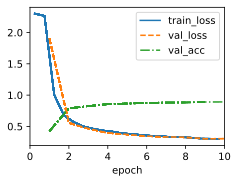

In [ ]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## Summary

One might argue that VGG is the first truly modern convolutional neural network. While AlexNet introduced many of the components of what make deep learning effective at scale, it is VGG that arguably introduced key properties such as blocks of multiple convolutions and a preference for deep and narrow networks. It is also the first network that is actually an entire family of similarly parametrized models, giving the practitioner ample trade-off between complexity and speed. This is also the place where modern deep learning frameworks shine. It is no longer necessary to generate XML configuration files to specify a network but rather, to assemble said networks through simple Python code.

More recently ParNet :cite:`Goyal.Bochkovskiy.Deng.ea.2021` demonstrated that it is possible to achieve competitive performance using a much more shallow architecture through a large number of parallel computations. This is an exciting development and there is hope that it will influence architecture designs in the future. For the remainder of the chapter, though, we will follow the path of scientific progress over the past decade.

## Exercises


1. Compared with AlexNet, VGG is much slower in terms of computation, and it also needs more GPU memory.
    1. Compare the number of parameters needed for AlexNet and VGG.
    2. Compare the number of floating point operations used in the convolutional layers and in the fully connected layers.
    3. How could you reduce the computational cost created by the fully connected layers?
2. When displaying the dimensions associated with the various layers of the network, we only see the information associated with eight blocks (plus some auxiliary transforms), even though the network has 11 layers. Where did the remaining three layers go?
3. Use Table 1 in the VGG paper :cite:`Simonyan.Zisserman.2014` to construct other common models, such as VGG-16 or VGG-19.
4. Upsampling the resolution in Fashion-MNIST eight-fold from $28 \times 28$ to $224 \times 224$ dimensions is very wasteful. Try modifying the network architecture and resolution conversion, e.g., to 56 or to 84 dimensions for its input instead. Can you do so without reducing the accuracy of the network? Consult the VGG paper :cite:`Simonyan.Zisserman.2014` for ideas on adding more nonlinearities prior to downsampling.


##**Answer Exercise**

**1. Dibandingkan dengan AlexNet, VGG jauh lebih lambat dalam hal komputasi, dan juga membutuhkan lebih banyak memori GPU.**

1.   Bandingkan jumlah parameter yang dibutuhkan untuk AlexNet dan VGG.

  *   AlexNet memiliki sekitar 60 juta parameter, sedangkan VGG-16 memiliki sekitar 138 juta parameter, yang berarti VGG membutuhkan lebih banyak memori untuk menyimpan parameternya. Perbedaan besar ini terutama disebabkan oleh arsitektur VGG yang lebih dalam dan penggunaan blok konvolusi bertumpuk.

2.   Bandingkan jumlah operasi floating point yang digunakan dalam layer konvolusi dan layer fully connected.

  *   Pada AlexNet, layer fully connected (FC) menyumbang sebagian besar operasi floating point (FLOPs), sedangkan pada VGG, layer konvolusionallah yang mendominasi. Ini karena VGG menggunakan lebih banyak layer konvolusi daripada FC, yang berarti sebagian besar perhitungan dilakukan pada tahap konvolusi.

3. Bagaimana Anda dapat mengurangi biaya komputasi yang disebabkan oleh layer fully connected?

  *   Salah satu cara untuk mengurangi biaya komputasi pada layer fully connected adalah dengan menggantinya dengan global average pooling, yang menghilangkan kebutuhan akan FC dan mengurangi jumlah parameter secara signifikan. Pendekatan ini telah diterapkan pada banyak model modern seperti GoogLeNet dan ResNet.


**2. Saat menampilkan dimensi yang terkait dengan berbagai layer jaringan, kita hanya melihat informasi yang terkait dengan delapan blok (ditambah beberapa transformasi tambahan), meskipun jaringan memiliki 11 layer. Ke mana tiga layer lainnya pergi?**

*   Tiga layer lainnya adalah layer pooling yang biasanya tidak dicatat sebagai bagian dari dimensi yang signifikan. Layer-layer ini bertanggung jawab untuk melakukan downsampling pada data dan tidak memiliki bobot pelatihan, sehingga kadang-kadang tidak ditampilkan saat memvisualisasikan dimensi jaringan.


**3. Gunakan Tabel 1 dalam makalah VGG untuk membangun model umum lainnya, seperti VGG-16 atau VGG-19.**

*   Berdasarkan Tabel 1 dari makalah VGG oleh Simonyan dan Zisserman (2014), model VGG-16 memiliki 13 layer konvolusi dan 3 layer fully connected, sementara VGG-19 memiliki 16 layer konvolusi dan 3 layer fully connected. Kamu dapat membangun model ini dengan menumpuk layer konvolusi sesuai dengan struktur yang dijelaskan dalam tabel tersebut.


**4. Upsampling resolusi di dataset Fashion-MNIST dari $28 \times 28$ menjadi $224 \times 224$ sangat boros. Cobalah memodifikasi arsitektur jaringan dan konversi resolusi, misalnya, menjadi 56 atau 84 dimensi untuk inputnya. Bisakah kamu melakukannya tanpa mengurangi akurasi jaringan? Konsultasikan makalah VGG untuk ide tentang menambahkan lebih banyak non-linearitas sebelum downsampling.**

*   Untuk mengurangi resolusi input menjadi 56 atau 84, Anda dapat menggunakan pooling atau convolutional stride untuk memperkecil resolusi gambar dengan cara yang lebih efisien. Selain itu, menambahkan layer non-linear seperti ReLU setelah setiap konvolusi dapat membantu model belajar representasi yang lebih kaya meskipun menggunakan resolusi yang lebih rendah. Menambahkan lebih banyak konvolusi sebelum downsampling juga dapat membantu menjaga akurasi.









#8.3 Network in Network (NiN)
:label:`sec_nin`

LeNet, AlexNet, and VGG all share a common design pattern:
extract features exploiting *spatial* structure
via a sequence of convolutions and pooling layers
and post-process the representations via fully connected layers.
The improvements upon LeNet by AlexNet and VGG mainly lie
in how these later networks widen and deepen these two modules.

This design poses two major challenges.
First, the fully connected layers at the end
of the architecture consume tremendous numbers of parameters. For instance, even a simple
model such as VGG-11 requires a monstrous matrix, occupying almost
400MB of RAM in single precision (FP32). This is a significant impediment to computation, in particular on
mobile and embedded devices. After all, even high-end mobile phones sport no more than 8GB of RAM. At the time VGG was invented, this was an order of magnitude less (the iPhone 4S had 512MB). As such, it would have been difficult to justify spending the majority of memory on an image classifier.

Second, it is equally impossible to add fully connected layers
earlier in the network to increase the degree of nonlinearity: doing so would destroy the
spatial structure and require potentially even more memory.

The *network in network* (*NiN*) blocks :cite:`Lin.Chen.Yan.2013` offer an alternative,
capable of solving both problems in one simple strategy.
They were proposed based on a very simple insight: (i) use $1 \times 1$ convolutions to add
local nonlinearities across the channel activations and (ii) use global average pooling to integrate
across all locations in the last representation layer. Note that global average pooling would not
be effective, were it not for the added nonlinearities. Let's dive into this in detail.


## (**NiN Blocks**)

Recall :numref:`subsec_1x1`. In it we said that the inputs and outputs of convolutional layers
consist of four-dimensional tensors with axes
corresponding to the example, channel, height, and width.
Also recall that the inputs and outputs of fully connected layers
are typically two-dimensional tensors corresponding to the example and feature.
The idea behind NiN is to apply a fully connected layer
at each pixel location (for each height and width).
The resulting $1 \times 1$ convolution can be thought of as
a fully connected layer acting independently on each pixel location.

:numref:`fig_nin` illustrates the main structural
differences between VGG and NiN, and their blocks.
Note both the difference in the NiN blocks (the initial convolution is followed by $1 \times 1$ convolutions, whereas VGG retains $3 \times 3$ convolutions) and at the end where we no longer require a giant fully connected layer.

![Comparing the architectures of VGG and NiN, and of their blocks.](http://d2l.ai/_images/nin.svg)
:width:`600px`
:label:`fig_nin`


In [ ]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

## [**NiN Model**]

NiN uses the same initial convolution sizes as AlexNet (it was proposed shortly thereafter).
The kernel sizes are $11\times 11$, $5\times 5$, and $3\times 3$, respectively,
and the numbers of output channels match those of AlexNet. Each NiN block is followed by a max-pooling layer
with a stride of 2 and a window shape of $3\times 3$.

The second significant difference between NiN and both AlexNet and VGG
is that NiN avoids fully connected layers altogether.
Instead, NiN uses a NiN block with a number of output channels equal to the number of label classes, followed by a *global* average pooling layer,
yielding a vector of logits.
This design significantly reduces the number of required model parameters, albeit at the expense of a potential increase in training time.


In [ ]:
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)

We create a data example to see [**the output shape of each block**].


In [ ]:
NiN().layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


## [**Training**]

As before we use Fashion-MNIST to train the model using the same
optimizer that we used for AlexNet and VGG.


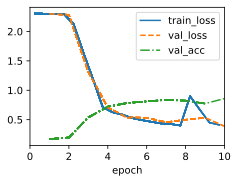

In [ ]:
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## Summary

NiN has dramatically fewer parameters than AlexNet and VGG. This stems primarily from the fact that it needs no giant fully connected layers. Instead, it uses global average pooling to aggregate across all image locations after the last stage of the network body. This obviates the need for expensive (learned) reduction operations and replaces them by a simple average. What surprised researchers at the time was the fact that this averaging operation did not harm accuracy. Note that averaging across a low-resolution representation (with many channels) also adds to the amount of translation invariance that the network can handle.

Choosing fewer convolutions with wide kernels and replacing them by $1 \times 1$ convolutions aids the quest for fewer parameters further. It can cater for a significant amount of nonlinearity across channels within any given location. Both $1 \times 1$ convolutions and global average pooling significantly influenced subsequent CNN designs.

## Exercises

1. Why are there two $1\times 1$ convolutional layers per NiN block? Increase their number to three. Reduce their number to one. What changes?
2. What changes if you replace the $1 \times 1$ convolutions by $3 \times 3$ convolutions?
3. What happens if you replace the global average pooling by a fully connected layer (speed, accuracy, number of parameters)?
4. Calculate the resource usage for NiN.
    1. What is the number of parameters?
    2. What is the amount of computation?
    3. What is the amount of memory needed during training?
    4. What is the amount of memory needed during prediction?
5. What are possible problems with reducing the $384 \times 5 \times 5$ representation to a $10 \times 5 \times 5$ representation in one step?
6. Use the structural design decisions in VGG that led to VGG-11, VGG-16, and VGG-19 to design a family of NiN-like networks.


## **Answer Exercise**

**1. Mengapa ada dua layer konvolusi $1 \times 1$ per blok NiN? Tambahkan jumlahnya menjadi tiga. Kurangi menjadi satu. Apa yang berubah?**

*   Dua layer konvolusi $1 \times 1$ digunakan untuk meningkatkan ekspresivitas dan nonlinearitas pada setiap blok, memungkinkan jaringan untuk belajar lebih banyak fitur. Jika jumlahnya ditambah menjadi tiga, jaringan dapat menangkap lebih banyak fitur dan meningkatkan kapasitas representasi, tetapi juga meningkatkan kompleksitas komputasi. Jika dikurangi menjadi satu, kapasitas ekspresi fitur akan berkurang, sehingga mungkin mengurangi kemampuan jaringan untuk mempelajari pola yang kompleks.


**2. Apa yang berubah jika kamu mengganti konvolusi $1 \times 1$ dengan konvolusi $3 \times 3$?**

*   Mengganti konvolusi $1 \times 1$ dengan $3 \times 3$ akan meningkatkan jumlah parameter secara signifikan, karena setiap kernel akan memiliki lebih banyak koneksi. Hal ini meningkatkan kapasitas komputasi dan memori yang diperlukan, tetapi juga dapat membantu jaringan menangkap lebih banyak informasi spasial dari data. Namun, ini bertentangan dengan tujuan NiN untuk mengurangi jumlah parameter.

**3. Apa yang terjadi jika kamu mengganti global average pooling dengan lapisan fully connected (kecepatan, akurasi, jumlah parameter)?**

*   Jika mengganti global average pooling dengan layer fully connected, jumlah parameter akan meningkat secara drastis, karena layer fully connected memerlukan banyak bobot yang harus dipelajari. Hal ini akan memperlambat kecepatan pelatihan dan inferensi karena operasi fully connected lebih kompleks. Akurasi mungkin sedikit meningkat karena lebih banyak parameter yang dapat dipelajari, tetapi ada risiko overfitting yang lebih besar, terutama jika dataset tidak cukup besar.


**4. Hitung penggunaan sumber daya untuk NiN.**
1. Berapa jumlah parameternya?

  *   Jumlah parameter pada NiN bergantung pada ukuran dan jumlah filter pada layer-layer konvolusi $1 \times 1$. Jumlah parameter dapat dihitung dengan mempertimbangkan semua layer konvolusi dan pooling.

2. Berapa jumlah perhitungan yang diperlukan?
  *   Perhitungan yang diperlukan ditentukan oleh jumlah operasi floating point per detik (FLOPs) di semua layer, termasuk operasi konvolusi dan pooling.
3. Berapa banyak memori yang dibutuhkan selama pelatihan?
  *   Memori selama pelatihan meliputi penyimpanan parameter model, gradien, dan aktivasi di setiap layer. Hal ini juga bergantung pada ukuran batch dan dimensi input.

4. Berapa banyak memori yang dibutuhkan selama prediksi?
  *   Memori selama prediksi hanya mencakup penyimpanan parameter dan aktivasi saat melakukan feedforward tanpa menyimpan gradien. Biasanya lebih sedikit dibandingkan selama pelatihan.


**5. Apa masalah potensial jika kamu mengurangi representasi $384 \times 5 \times 5$ menjadi $10 \times 5 \times 5$ dalam satu langkah?**
*   Mengurangi representasi secara drastis dalam satu langkah dapat menghilangkan banyak informasi penting yang tersimpan di dalam representasi spasial. Hal ini dapat menyebabkan kehilangan detail dalam fitur yang dipelajari dan merusak akurasi model secara keseluruhan. Pengurangan bertahap melalui beberapa layer akan lebih aman dan efektif.

**6. Gunakan keputusan desain struktural dalam VGG yang mengarah ke VGG-11, VGG-16, dan VGG-19 untuk merancang keluarga jaringan seperti NiN.**

*   Seperti pada VGG, kita bisa mendesain keluarga jaringan NiN dengan menggunakan pendekatan modular, misalnya, membuat versi NiN dengan lebih banyak blok konvolusi atau menambah/mengurangi layer konvolusi $1 \times 1$ dalam setiap blok. Kita bisa merancang NiN-11 dengan 11 layer konvolusi, NiN-16 dengan 16 layer, atau NiN-19 dengan 19 layer, mengikuti pola yang sama seperti keluarga VGG, sambil tetap mempertahankan penggunaan global average pooling untuk menjaga efisiensi.






#8.4 Multi-Branch Networks  (GoogLeNet)
:label:`sec_googlenet`

In 2014, *GoogLeNet*
won the ImageNet Challenge :cite:`Szegedy.Liu.Jia.ea.2015`, using a structure
that combined the strengths of NiN :cite:`Lin.Chen.Yan.2013`, repeated blocks :cite:`Simonyan.Zisserman.2014`,
and a cocktail of convolution kernels. It was arguably also the first network that exhibited a clear distinction among the stem (data ingest), body (data processing), and head (prediction) in a CNN. This design pattern has persisted ever since in the design of deep networks: the *stem* is given by the first two or three convolutions that operate on the image. They extract low-level features from the underlying images. This is followed by a *body* of convolutional blocks. Finally, the *head* maps the features obtained so far to the required classification, segmentation, detection, or tracking problem at hand.

The key contribution in GoogLeNet was the design of the network body. It solved the problem of selecting
convolution kernels in an ingenious way. While other works tried to identify which convolution, ranging from $1 \times 1$ to $11 \times 11$ would be best, it simply *concatenated* multi-branch convolutions.
In what follows we introduce a slightly simplified version of GoogLeNet: the original design included a number of tricks for stabilizing training through intermediate loss functions, applied to multiple layers of the network.
They are no longer necessary due to the availability of improved training algorithms.


## (**Inception Blocks**)

The basic convolutional block in GoogLeNet is called an *Inception block*,
stemming from the meme "we need to go deeper" from the movie *Inception*.

![Structure of the Inception block.](http://d2l.ai/_images/inception.svg)
:label:`fig_inception`

As depicted in :numref:`fig_inception`,
the inception block consists of four parallel branches.
The first three branches use convolutional layers
with window sizes of $1\times 1$, $3\times 3$, and $5\times 5$
to extract information from different spatial sizes.
The middle two branches also add a $1\times 1$ convolution of the input
to reduce the number of channels, reducing the model's complexity.
The fourth branch uses a $3\times 3$ max-pooling layer,
followed by a $1\times 1$ convolutional layer
to change the number of channels.
The four branches all use appropriate padding to give the input and output the same height and width.
Finally, the outputs along each branch are concatenated
along the channel dimension and comprise the block's output.
The commonly-tuned hyperparameters of the Inception block
are the number of output channels per layer, i.e., how to allocate capacity among convolutions of different size.


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [ ]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

To gain some intuition for why this network works so well,
consider the combination of the filters.
They explore the image in a variety of filter sizes.
This means that details at different extents
can be recognized efficiently by filters of different sizes.
At the same time, we can allocate different amounts of parameters
for different filters.


## [**GoogLeNet Model**]

As shown in :numref:`fig_inception_full`, GoogLeNet uses a stack of a total of 9 inception blocks, arranged into three groups with max-pooling in between,
and global average pooling in its head to generate its estimates.
Max-pooling between inception blocks reduces the dimensionality.
At its stem, the first module is similar to AlexNet and LeNet.

![The GoogLeNet architecture.](../img/inception-full-90.svg)
:label:`fig_inception_full`

We can now implement GoogLeNet piece by piece. Let's begin with the stem.
The first module uses a 64-channel $7\times 7$ convolutional layer.


In [ ]:
class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The second module uses two convolutional layers:
first, a 64-channel $1\times 1$ convolutional layer,
followed by a $3\times 3$ convolutional layer that triples the number of channels. This corresponds to the second branch in the Inception block and concludes the design of the body. At this point we have 192 channels.


In [ ]:
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The third module connects two complete Inception blocks in series.
The number of output channels of the first Inception block is
$64+128+32+32=256$. This amounts to
a ratio of the number of output channels
among the four branches of $2:4:1:1$. To achieve this, we first reduce the input
dimensions by $\frac{1}{2}$ and by $\frac{1}{12}$ in the second and third branch respectively
to arrive at $96 = 192/2$ and $16 = 192/12$ channels respectively.

The number of output channels of the second Inception block
is increased to $128+192+96+64=480$, yielding a ratio of $128:192:96:64 = 4:6:3:2$. As before,
we need to reduce the number of intermediate dimensions in the second and third channel. A
scale of $\frac{1}{2}$ and $\frac{1}{8}$ respectively suffices, yielding $128$ and $32$ channels
respectively. This is captured by the arguments of the following `Inception` block constructors.


In [ ]:
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The fourth module is more complicated.
It connects five Inception blocks in series,
and they have $192+208+48+64=512$, $160+224+64+64=512$,
$128+256+64+64=512$, $112+288+64+64=528$,
and $256+320+128+128=832$ output channels, respectively.
The number of channels assigned to these branches is similar
to that in the third module:
the second branch with the $3\times 3$ convolutional layer
outputs the largest number of channels,
followed by the first branch with only the $1\times 1$ convolutional layer,
the third branch with the $5\times 5$ convolutional layer,
and the fourth branch with the $3\times 3$ max-pooling layer.
The second and third branches will first reduce
the number of channels according to the ratio.
These ratios are slightly different in different Inception blocks.


In [ ]:
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The fifth module has two Inception blocks with $256+320+128+128=832$
and $384+384+128+128=1024$ output channels.
The number of channels assigned to each branch
is the same as that in the third and fourth modules,
but differs in specific values.
It should be noted that the fifth block is followed by the output layer.
This block uses the global average pooling layer
to change the height and width of each channel to 1, just as in NiN.
Finally, we turn the output into a two-dimensional array
followed by a fully connected layer
whose number of outputs is the number of label classes.


In [ ]:
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

Now that we defined all blocks `b1` through `b5`, it is just a matter of assembling them all into a full network.


In [ ]:
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

The GoogLeNet model is computationally complex. Note the large number of
relatively arbitrary hyperparameters in terms of the number of channels chosen, the number of blocks prior to dimensionality reduction, the relative partitioning of capacity across channels, etc. Much of it is due to the
fact that at the time when GoogLeNet was introduced, automatic tools for network definition or design exploration
were not yet available. For instance, by now we take it for granted that a competent deep learning framework is capable of inferring dimensionalities of input tensors automatically. At the time, many such configurations had to be specified explicitly by the experimenter, thus often slowing down active experimentation. Moreover, the tools needed for automatic exploration were still in flux and initial experiments largely amounted to costly brute-force exploration, genetic algorithms, and similar strategies.

For now the only modification we will carry out is to
[**reduce the input height and width from 224 to 96
to have a reasonable training time on Fashion-MNIST.**]
This simplifies the computation. Let's have a look at the
changes in the shape of the output between the various modules.


In [ ]:
model = GoogleNet().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


## [**Training**]

As before, we train our model using the Fashion-MNIST dataset.
 We transform it to $96 \times 96$ pixel resolution
 before invoking the training procedure.


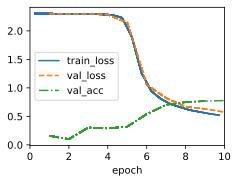

In [ ]:
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## Discussion

A key feature of GoogLeNet is that it is actually *cheaper* to compute than its predecessors
while simultaneously providing improved accuracy. This marks the beginning of a much more deliberate
network design that trades off the cost of evaluating a network with a reduction in errors. It also marks the beginning of experimentation at a block level with network design hyperparameters, even though it was entirely manual at the time. We will revisit this topic in :numref:`sec_cnn-design` when discussing strategies for network structure exploration.

Over the following sections we will encounter a number of design choices (e.g., batch normalization, residual connections, and channel grouping) that allow us to improve networks significantly. For now, you can be proud to have implemented what is arguably the first truly modern CNN.

## Exercises

1. GoogLeNet was so successful that it went through a number of iterations, progressively improving speed and accuracy. Try to implement and run some of them. They include the following:
    1. Add a batch normalization layer :cite:`Ioffe.Szegedy.2015`, as described later in :numref:`sec_batch_norm`.
    2. Make adjustments to the Inception block (width, choice and order of convolutions), as described in :citet:`Szegedy.Vanhoucke.Ioffe.ea.2016`.
    3. Use label smoothing for model regularization, as described in :citet:`Szegedy.Vanhoucke.Ioffe.ea.2016`.
    4. Make further adjustments to the Inception block by adding residual connection :cite:`Szegedy.Ioffe.Vanhoucke.ea.2017`, as described later in :numref:`sec_resnet`.
2. What is the minimum image size needed for GoogLeNet to work?
3. Can you design a variant of GoogLeNet that works on Fashion-MNIST's native resolution of $28 \times 28$ pixels? How would you need to change the stem, the body, and the head of the network, if anything at all?
4. Compare the model parameter sizes of AlexNet, VGG, NiN, and GoogLeNet. How do the latter two network
   architectures significantly reduce the model parameter size?
5. Compare the amount of computation needed in GoogLeNet and AlexNet. How does this affect the design of an accelerator chip, e.g., in terms of memory size, memory bandwidth, cache size, the amount of computation, and the benefit of specialized operations?


## **Answer Exercise**

**1. GoogLeNet begitu sukses sehingga melalui beberapa iterasi, yang secara bertahap meningkatkan kecepatan dan akurasi. Cobalah mengimplementasikan dan menjalankan beberapa iterasi tersebut. Mereka termasuk:**
1. Menambahkan lapisan batch normalization :cite:`Ioffe.Szegedy.2015`, seperti dijelaskan kemudian di :numref:sec_batch_norm.

  *   Implementasi lapisan batch normalization membantu jaringan dalam mempercepat pelatihan dan meningkatkan stabilitas dengan menormalkan aktivasi pada setiap mini-batch. Hal ini mengurangi masalah internal covariate shift.

2. Membuat penyesuaian pada blok Inception (lebar, pilihan, dan urutan konvolusi), seperti dijelaskan dalam :cite:Szegedy.Vanhoucke.Ioffe.ea.2016.

  *   Penyesuaian blok Inception seperti mengubah ukuran filter atau mengatur ulang urutan konvolusi memungkinkan jaringan menangkap berbagai skala fitur yang lebih baik dan mengurangi jumlah parameter.

3. Menggunakan label smoothing untuk regularisasi model, seperti dijelaskan dalam :cite:`Szegedy.Vanhoucke.Ioffe.ea.2016`.
  *   Label smoothing membantu dalam menghindari overfitting dengan mendistribusikan kembali probabilitas ke label yang salah. Ini membuat model tidak terlalu percaya diri pada prediksi tertentu, yang dapat meningkatkan generalisasi.

4.  Membuat penyesuaian lebih lanjut pada blok Inception dengan menambahkan residual connection :cite:`Szegedy.Ioffe.Vanhoucke.ea.2017`, seperti dijelaskan kemudian di :numref:`sec_resnet`.
  *   Penambahan residual connections membantu mencegah masalah vanishing gradient, memungkinkan jaringan menjadi lebih dalam tanpa kehilangan performa. Ini membantu mempertahankan gradien yang lebih kuat selama pelatihan.

**2.  Berapa ukuran gambar minimum yang diperlukan untuk GoogLeNet dapat berfungsi?**
*   GoogLeNet dirancang untuk bekerja dengan gambar ukuran 224 x 224 piksel, yang merupakan ukuran input standar untuk banyak model CNN modern. Namun, ukuran minimum dapat bervariasi tergantung pada arsitektur spesifik dan modifikasi pada jaringan. Untuk versi standar GoogLeNet, ukuran gambar di bawah 32x32 mungkin tidak memungkinkan jaringan bekerja optimal karena resolusi terlalu rendah untuk ekstraksi fitur yang baik.


**3. Bisakah Anda merancang varian GoogLeNet yang berfungsi pada resolusi asli Fashion-MNIST sebesar $28 \times 28$ piksel? Bagaimana Anda perlu mengubah stem, body, dan head dari jaringan, jika perlu?**

*   Untuk menangani resolusi yang lebih rendah seperti 28 x 28 pada Fashion-MNIST, Anda bisa menyederhanakan stem dari jaringan dengan mengurangi jumlah lapisan konvolusi atau ukuran filter awal. Anda mungkin juga perlu menyesuaikan ukuran stride dan pooling agar sesuai dengan dimensi gambar yang lebih kecil, serta mengurangi kompleksitas body jaringan dengan lebih sedikit blok Inception. Head jaringan bisa tetap sama dengan penyesuaian kecil pada lapisan fully connected akhir.

**4. Bandingkan ukuran parameter model dari AlexNet, VGG, NiN, dan GoogLeNet. Bagaimana dua arsitektur terakhir (NiN dan GoogLeNet) secara signifikan mengurangi ukuran parameter model?**


*   AlexNet: Memiliki sekitar 60 juta parameter, sebagian besar berasal dari lapisan fully connected yang besar.
*   VGG: Juga memiliki banyak parameter (sekitar 138 juta untuk VGG-16), karena menggunakan lapisan fully connected besar dan konvolusi yang lebih dalam.
*   NiN: Menggunakan konvolusi $1 \times 1$ yang mengurangi jumlah parameter, serta menggantikan fully connected dengan global average pooling, secara signifikan mengurangi ukuran model.
*  GoogLeNet: Mengurangi parameter dengan menggunakan blok Inception yang menggabungkan konvolusi dengan ukuran kernel yang berbeda, dan juga mengganti lapisan fully connected dengan global average pooling, mengurangi jumlah parameter menjadi sekitar 7 juta.

**5. Bandingkan jumlah komputasi yang dibutuhkan di GoogLeNet dan AlexNet. Bagaimana hal ini memengaruhi desain chip akselerator, misalnya, dalam hal ukuran memori, bandwidth memori, ukuran cache, jumlah komputasi, dan manfaat dari operasi khusus?**

*  GoogLeNet jauh lebih efisien secara komputasi dibandingkan AlexNet meskipun memiliki arsitektur yang lebih kompleks, karena menggunakan blok Inception yang menggabungkan beberapa operasi konvolusi dalam cara yang lebih paralel dan efisien.
*  Desain chip akselerator untuk GoogLeNet dapat dioptimalkan dengan memanfaatkan operasi paralel pada blok Inception, yang dapat mengurangi kebutuhan memori dan bandwidth dibandingkan dengan AlexNet. Ukuran cache bisa lebih kecil karena operasi blok yang efisien, dan jumlah komputasi dapat difokuskan pada operasi konvolusi yang lebih kecil (seperti $1 \times 1$). Operasi khusus seperti global average pooling juga mengurangi beban komputasi dari operasi fully connected yang besar pada AlexNet.





#8.5 Batch Normalization
:label:`sec_batch_norm`

Training deep neural networks is difficult.
Getting them to converge in a reasonable amount of time can be tricky.
In this section, we describe *batch normalization*, a popular and effective technique
that consistently accelerates the convergence of deep networks :cite:`Ioffe.Szegedy.2015`.
Together with residual blocks---covered later in :numref:`sec_resnet`---batch normalization
has made it possible for practitioners to routinely train networks with over 100 layers.
A secondary (serendipitous) benefit of batch normalization lies in its inherent regularization.


## Training Deep Networks

When working with data, we often preprocess before training.
Choices regarding data preprocessing often make an enormous difference in the final results.
Recall our application of MLPs to predicting house prices (:numref:`sec_kaggle_house`).
Our first step when working with real data
was to standardize our input features to have
zero mean $\boldsymbol{\mu} = 0$ and unit variance $\boldsymbol{\Sigma} = \boldsymbol{1}$ across multiple observations :cite:`friedman1987exploratory`, frequently rescaling the latter so  that the diagonal is unity, i.e., $\Sigma_{ii} = 1$.
Yet another strategy is to rescale vectors to unit length, possibly zero mean *per observation*.
This can work well, e.g., for spatial sensor data. These preprocessing techniques and many others, are
beneficial for keeping the estimation problem well controlled.
For a review of feature selection and extraction see the article of :citet:`guyon2008feature`, for example.
Standardizing vectors also has the nice side-effect of constraining the function complexity of functions that act upon it. For instance, the celebrated radius-margin bound :cite:`Vapnik95` in support vector machines and the Perceptron Convergence Theorem :cite:`Novikoff62` rely on inputs of bounded norm.

Intuitively, this standardization plays nicely with our optimizers
since it puts the parameters *a priori* on a similar scale.
As such, it is only natural to ask whether a corresponding normalization step *inside* a deep network
might not be beneficial. While this is not quite the reasoning that led to the invention of batch normalization :cite:`Ioffe.Szegedy.2015`, it is a useful way of understanding it and its cousin, layer normalization :cite:`Ba.Kiros.Hinton.2016`, within a unified framework.

Second, for a typical MLP or CNN, as we train,
the variables
in intermediate layers (e.g., affine transformation outputs in MLP)
may take values with widely varying magnitudes:
whether along the layers from input to output, across units in the same layer,
and over time due to our updates to the model parameters.
The inventors of batch normalization postulated informally
that this drift in the distribution of such variables could hamper the convergence of the network.
Intuitively, we might conjecture that if one
layer has variable activations that are 100 times that of another layer,
this might necessitate compensatory adjustments in the learning rates. Adaptive solvers
such as AdaGrad :cite:`Duchi.Hazan.Singer.2011`, Adam :cite:`Kingma.Ba.2014`, Yogi :cite:`Zaheer.Reddi.Sachan.ea.2018`, or Distributed Shampoo :cite:`anil2020scalable` aim to address this from the viewpoint of optimization, e.g., by adding aspects of second-order methods.
The alternative is to prevent the problem from occurring, simply by adaptive normalization.

Third, deeper networks are complex and tend to be more liable to overfitting.
This means that regularization becomes more critical. A common technique for regularization is noise
injection. This has been known for a long time, e.g., with regard to noise injection for the
inputs :cite:`Bishop.1995`. It also forms the basis of dropout in :numref:`sec_dropout`. As it turns out, quite serendipitously, batch normalization conveys all three benefits: preprocessing, numerical stability, and regularization.

Batch normalization is applied to individual layers, or optionally, to all of them:
In each training iteration,
we first normalize the inputs (of batch normalization)
by subtracting their mean and
dividing by their standard deviation,
where both are estimated based on the statistics of the current minibatch.
Next, we apply a scale coefficient and an offset to recover the lost degrees
of freedom. It is precisely due to this *normalization* based on *batch* statistics
that *batch normalization* derives its name.

Note that if we tried to apply batch normalization with minibatches of size 1,
we would not be able to learn anything.
That is because after subtracting the means,
each hidden unit would take value 0.
As you might guess, since we are devoting a whole section to batch normalization,
with large enough minibatches the approach proves effective and stable.
One takeaway here is that when applying batch normalization,
the choice of batch size is
even more significant than without batch normalization, or at least,
suitable calibration is needed as we might adjust batch size.

Denote by $\mathcal{B}$ a minibatch and let $\mathbf{x} \in \mathcal{B}$ be an input to
batch normalization ($\textrm{BN}$). In this case the batch normalization is defined as follows:

$$\textrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}.$$
:eqlabel:`eq_batchnorm`

In :eqref:`eq_batchnorm`,
$\hat{\boldsymbol{\mu}}_\mathcal{B}$ is the  sample mean
and $\hat{\boldsymbol{\sigma}}_\mathcal{B}$ is the sample standard deviation of the minibatch $\mathcal{B}$.
After applying standardization,
the resulting minibatch
has zero mean and unit variance.
The choice of unit variance
(rather than some other magic number) is arbitrary. We recover this degree of freedom
by including an elementwise
*scale parameter* $\boldsymbol{\gamma}$ and *shift parameter* $\boldsymbol{\beta}$
that have the same shape as $\mathbf{x}$. Both are parameters that
need to be learned as part of model training.

The variable magnitudes
for intermediate layers cannot diverge during training
since batch normalization actively centers and rescales them back
to a given mean and size (via $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$).
Practical experience confirms that, as alluded to when discussing feature rescaling, batch normalization seems to allow for more aggressive learning rates.
We calculate $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ in :eqref:`eq_batchnorm` as follows:

$$\hat{\boldsymbol{\mu}}_\mathcal{B} = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x}
\textrm{ and }
\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.$$

Note that we add a small constant $\epsilon > 0$
to the variance estimate
to ensure that we never attempt division by zero,
even in cases where the empirical variance estimate might be very small or vanish.
The estimates $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ counteract the scaling issue
by using noisy estimates of mean and variance.
You might think that this noisiness should be a problem.
On the contrary, it is actually beneficial.

This turns out to be a recurring theme in deep learning.
For reasons that are not yet well-characterized theoretically,
various sources of noise in optimization
often lead to faster training and less overfitting:
this variation appears to act as a form of regularization.
:citet:`Teye.Azizpour.Smith.2018` and :citet:`Luo.Wang.Shao.ea.2018`
related the properties of batch normalization to Bayesian priors and penalties, respectively.
In particular, this sheds some light on the puzzle
of why batch normalization works best for moderate minibatch sizes in the 50--100 range.
This particular size of minibatch seems to inject just the "right amount" of noise per layer, both in terms of scale via $\hat{\boldsymbol{\sigma}}$, and in terms of offset via $\hat{\boldsymbol{\mu}}$: a
larger minibatch regularizes less due to the more stable estimates, whereas tiny minibatches
destroy useful signal due to high variance. Exploring this direction further, considering alternative types
of preprocessing and filtering may yet lead to other effective types of regularization.

Fixing a trained model, you might think
that we would prefer using the entire dataset
to estimate the mean and variance.
Once training is complete, why would we want
the same image to be classified differently,
depending on the batch in which it happens to reside?
During training, such exact calculation is infeasible
because the intermediate variables
for all data examples
change every time we update our model.
However, once the model is trained,
we can calculate the means and variances
of each layer's variables based on the entire dataset.
Indeed this is standard practice for
models employing batch normalization;
thus batch normalization layers function differently
in *training mode* (normalizing by minibatch statistics)
than in *prediction mode* (normalizing by dataset statistics).
In this form they closely resemble the behavior of dropout regularization of :numref:`sec_dropout`,
where noise is only injected during training.


## Batch Normalization Layers

Batch normalization implementations for fully connected layers
and convolutional layers are slightly different.
One key difference between batch normalization and other layers
is that because the former operates on a full minibatch at a time,
we cannot just ignore the batch dimension
as we did before when introducing other layers.

### Fully Connected Layers

When applying batch normalization to fully connected layers,
:citet:`Ioffe.Szegedy.2015`, in their original paper inserted batch normalization after the affine transformation
and *before* the nonlinear activation function. Later applications experimented with
inserting batch normalization right *after* activation functions.
Denoting the input to the fully connected layer by $\mathbf{x}$,
the affine transformation
by $\mathbf{W}\mathbf{x} + \mathbf{b}$ (with the weight parameter $\mathbf{W}$ and the bias parameter $\mathbf{b}$),
and the activation function by $\phi$,
we can express the computation of a batch-normalization-enabled,
fully connected layer output $\mathbf{h}$ as follows:

$$\mathbf{h} = \phi(\textrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ).$$

Recall that mean and variance are computed
on the *same* minibatch
on which the transformation is applied.

### Convolutional Layers

Similarly, with convolutional layers,
we can apply batch normalization after the convolution
but before the nonlinear activation function. The key difference from batch normalization
in fully connected layers is that we apply the operation on a per-channel basis
*across all locations*. This is compatible with our assumption of translation
invariance that led to convolutions: we assumed that the specific location of a pattern
within an image was not critical for the purpose of understanding.

Assume that our minibatches contain $m$ examples
and that for each channel,
the output of the convolution has height $p$ and width $q$.
For convolutional layers, we carry out each batch normalization
over the $m \cdot p \cdot q$ elements per output channel simultaneously.
Thus, we collect the values over all spatial locations
when computing the mean and variance
and consequently
apply the same mean and variance
within a given channel
to normalize the value at each spatial location.
Each channel has its own scale and shift parameters,
both of which are scalars.

### Layer Normalization
:label:`subsec_layer-normalization-in-bn`

Note that in the context of convolutions the batch normalization is well defined even for
minibatches of size 1: after all, we have all the locations across an image to average. Consequently,
mean and variance are well defined, even if it is just within a single observation. This consideration
led :citet:`Ba.Kiros.Hinton.2016` to introduce the notion of *layer normalization*. It works just like
a batch norm, only that it is applied to one observation at a time. Consequently both the offset and the scaling factor are scalars. For an $n$-dimensional vector $\mathbf{x}$, layer norms are given by

$$\mathbf{x} \rightarrow \textrm{LN}(\mathbf{x}) =  \frac{\mathbf{x} - \hat{\mu}}{\hat\sigma},$$

where scaling and offset are applied coefficient-wise
and given by

$$\hat{\mu} \stackrel{\textrm{def}}{=} \frac{1}{n} \sum_{i=1}^n x_i \textrm{ and }
\hat{\sigma}^2 \stackrel{\textrm{def}}{=} \frac{1}{n} \sum_{i=1}^n (x_i - \hat{\mu})^2 + \epsilon.$$

As before we add a small offset $\epsilon > 0$ to prevent division by zero. One of the major benefits of using layer normalization is that it prevents divergence. After all, ignoring $\epsilon$, the output of the layer normalization is scale independent. That is, we have $\textrm{LN}(\mathbf{x}) \approx \textrm{LN}(\alpha \mathbf{x})$ for any choice of $\alpha \neq 0$. This becomes an equality for $|\alpha| \to \infty$ (the approximate equality is due to the offset $\epsilon$ for the variance).

Another advantage of the layer normalization is that it does not depend on the minibatch size. It is also independent of whether we are in training or test regime. In other words, it is simply a deterministic transformation that standardizes the activations to a given scale. This can be very beneficial in preventing divergence in optimization. We skip further details and recommend that interested readers consult the original paper.

### Batch Normalization During Prediction

As we mentioned earlier, batch normalization typically behaves differently
in training mode than in prediction mode.
First, the noise in the sample mean and the sample variance
arising from estimating each on minibatches
is no longer desirable once we have trained the model.
Second, we might not have the luxury
of computing per-batch normalization statistics.
For example,
we might need to apply our model to make one prediction at a time.

Typically, after training, we use the entire dataset
to compute stable estimates of the variable statistics
and then fix them at prediction time.
Hence, batch normalization behaves differently during training than at test time.
Recall that dropout also exhibits this characteristic.

## (**Implementation from Scratch**)

To see how batch normalization works in practice, we implement one from scratch below.


In [ ]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

We can now [**create a proper `BatchNorm` layer.**]
Our layer will maintain proper parameters
for scale `gamma` and shift `beta`,
both of which will be updated in the course of training.
Additionally, our layer will maintain
moving averages of the means and variances
for subsequent use during model prediction.

Putting aside the algorithmic details,
note the design pattern underlying our implementation of the layer.
Typically, we define the mathematics in a separate function, say `batch_norm`.
We then integrate this functionality into a custom layer,
whose code mostly addresses bookkeeping matters,
such as moving data to the right device context,
allocating and initializing any required variables,
keeping track of moving averages (here for mean and variance), and so on.
This pattern enables a clean separation of mathematics from boilerplate code.
Also note that for the sake of convenience
we did not worry about automatically inferring the input shape here;
thus we need to specify the number of features throughout.
By now all modern deep learning frameworks offer automatic detection of size and shape in the
high-level batch normalization APIs (in practice we will use this instead).


In [ ]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

We used `momentum` to govern the aggregation over past mean and variance estimates. This is somewhat of a misnomer as it has nothing whatsoever to do with the *momentum* term of optimization. Nonetheless, it is the commonly adopted name for this term and in deference to API naming convention we use the same variable name in our code.

## [**LeNet with Batch Normalization**]

To see how to apply `BatchNorm` in context,
below we apply it to a traditional LeNet model (:numref:`sec_lenet`).
Recall that batch normalization is applied
after the convolutional layers or fully connected layers
but before the corresponding activation functions.


In [ ]:
class BNLeNetScratch(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), BatchNorm(6, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120),
            BatchNorm(120, num_dims=2), nn.Sigmoid(), nn.LazyLinear(84),
            BatchNorm(84, num_dims=2), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

As before, we will [**train our network on the Fashion-MNIST dataset**].
This code is virtually identical to that when we first trained LeNet.


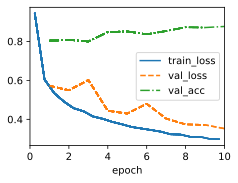

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNetScratch(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

Let's [**have a look at the scale parameter `gamma`
and the shift parameter `beta`**] learned
from the first batch normalization layer.


In [ ]:
model.net[1].gamma.reshape((-1,)), model.net[1].beta.reshape((-1,))

(tensor([1.7283, 2.1640, 1.5319, 1.7878, 1.7634, 1.8715], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([ 1.3856,  0.7817,  1.1143,  1.2834,  0.8478, -1.2388], device='cuda:0',
        grad_fn=<ViewBackward0>))

## [**Concise Implementation**]

Compared with the `BatchNorm` class,
which we just defined ourselves,
we can use the `BatchNorm` class defined in high-level APIs from the deep learning framework directly.
The code looks virtually identical
to our implementation above, except that we no longer need to provide additional arguments for it to get the dimensions right.


In [ ]:
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))

Below, we [**use the same hyperparameters to train our model.**]
Note that as usual, the high-level API variant runs much faster
because its code has been compiled to C++ or CUDA
while our custom implementation must be interpreted by Python.


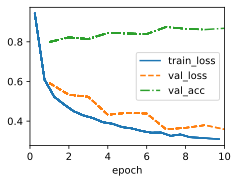

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## Discussion

Intuitively, batch normalization is thought
to make the optimization landscape smoother.
However, we must be careful to distinguish between
speculative intuitions and true explanations
for the phenomena that we observe when training deep models.
Recall that we do not even know why simpler
deep neural networks (MLPs and conventional CNNs)
generalize well in the first place.
Even with dropout and weight decay,
they remain so flexible that their ability to generalize to unseen data
likely needs significantly more refined learning-theoretic generalization guarantees.

The original paper proposing batch normalization :cite:`Ioffe.Szegedy.2015`, in addition to introducing a powerful and useful tool,
offered an explanation for why it works:
by reducing *internal covariate shift*.
Presumably by *internal covariate shift* they
meant something like the intuition expressed above---the
notion that the distribution of variable values changes
over the course of training.
However, there were two problems with this explanation:
i) This drift is very different from *covariate shift*,
rendering the name a misnomer. If anything, it is closer to concept drift.
ii) The explanation offers an under-specified intuition
but leaves the question of *why precisely this technique works*
an open question wanting for a rigorous explanation.
Throughout this book, we aim to convey the intuitions that practitioners
use to guide their development of deep neural networks.
However, we believe that it is important
to separate these guiding intuitions
from established scientific fact.
Eventually, when you master this material
and start writing your own research papers
you will want to be clear to delineate
between technical claims and hunches.

Following the success of batch normalization,
its explanation in terms of *internal covariate shift*
has repeatedly surfaced in debates in the technical literature
and broader discourse about how to present machine learning research.
In a memorable speech given while accepting a Test of Time Award
at the 2017 NeurIPS conference,
Ali Rahimi used *internal covariate shift*
as a focal point in an argument likening
the modern practice of deep learning to alchemy.
Subsequently, the example was revisited in detail
in a position paper outlining
troubling trends in machine learning :cite:`Lipton.Steinhardt.2018`.
Other authors
have proposed alternative explanations for the success of batch normalization,
some :cite:`Santurkar.Tsipras.Ilyas.ea.2018`
claiming that batch normalization's success comes despite exhibiting behavior
that is in some ways opposite to those claimed in the original paper.


We note that the *internal covariate shift*
is no more worthy of criticism than any of
thousands of similarly vague claims
made every year in the technical machine learning literature.
Likely, its resonance as a focal point of these debates
owes to its broad recognizability for the target audience.
Batch normalization has proven an indispensable method,
applied in nearly all deployed image classifiers,
earning the paper that introduced the technique
tens of thousands of citations. We conjecture, though, that the guiding principles
of regularization through noise injection, acceleration through rescaling and lastly preprocessing
may well lead to further inventions of layers and techniques in the future.

On a more practical note, there are a number of aspects worth remembering about batch normalization:

* During model training, batch normalization continuously adjusts the intermediate output of
  the network by utilizing the mean and standard deviation of the minibatch, so that the
  values of the intermediate output in each layer throughout the neural network are more stable.
* Batch normalization is slightly different for fully connected layers than for convolutional layers. In fact,
  for convolutional layers, layer normalization can sometimes be used as an alternative.
* Like a dropout layer, batch normalization layers have different behaviors
  in training mode than in prediction mode.
* Batch normalization is useful for regularization and improving convergence in optimization. By contrast,
  the original motivation of reducing internal covariate shift seems not to be a valid explanation.
* For more robust models that are less sensitive to input perturbations, consider removing batch normalization :cite:`wang2022removing`.

## Exercises

1. Should we remove the bias parameter from the fully connected layer or the convolutional layer before the batch normalization? Why?
2. Compare the learning rates for LeNet with and without batch normalization.
    1. Plot the increase in validation accuracy.
    2. How large can you make the learning rate before the optimization fails in both cases?
3. Do we need batch normalization in every layer? Experiment with it.
4. Implement a "lite" version of batch normalization that only removes the mean, or alternatively one that
   only removes the variance. How does it behave?
5. Fix the parameters `beta` and `gamma`. Observe and analyze the results.
6. Can you replace dropout by batch normalization? How does the behavior change?
7. Research ideas: think of other normalization transforms that you can apply:
    1. Can you apply the probability integral transform?
    2. Can you use a full-rank covariance estimate? Why should you probably not do that?
    3. Can you use other compact matrix variants (block-diagonal, low-displacement rank, Monarch, etc.)?
    4. Does a sparsification compression act as a regularizer?
    5. Are there other projections (e.g., convex cone, symmetry group-specific transforms) that you can use?


## **Answer Exercise**

**1. Haruskah kita menghapus parameter bias dari lapisan fully connected atau lapisan konvolusi sebelum batch normalization? Mengapa?**

*   Ya, kita harus menghapus parameter bias sebelum batch normalization karena batch normalization sudah mengurangi bias dengan menormalkan output. Menambahkan bias lagi akan menjadi operasi yang tidak diperlukan dan tidak efektif.

**2. Bandingkan learning rate untuk LeNet dengan dan tanpa batch normalization.**

1.   Plot peningkatan akurasi validasi

  *   Dengan batch normalization, kita dapat menggunakan learning rate yang lebih tinggi tanpa menyebabkan masalah divergensi dalam pelatihan, sehingga meningkatkan akurasi validasi lebih cepat daripada tanpa batch normalization.

2.   Seberapa besar Anda bisa meningkatkan learning rate sebelum optimisasi gagal pada kedua kasus?
  *   Dengan batch normalization, learning rate dapat dinaikkan lebih tinggi daripada tanpa batch normalization (misalnya dari 0.01 menjadi 0.1) sebelum optimisasi gagal, karena batch normalization membantu stabilisasi gradien.

**3. Apakah kita memerlukan batch normalization di setiap lapisan? Cobalah bereksperimen.**

*   Tidak semua lapisan membutuhkan batch normalization. Batch normalization lebih efektif di lapisan yang memiliki gradien yang lebih dalam atau memiliki potensi perubahan distribusi data yang signifikan. Pada lapisan input atau lapisan shallow, batch normalization mungkin tidak terlalu diperlukan.

**4. Implementasikan versi "lite" dari batch normalization yang hanya menghilangkan mean, atau hanya menghilangkan varians. Bagaimana perilakunya?**
*    Jika kita hanya menghilangkan mean, outputnya tetap memiliki skala yang bervariasi yang dapat menyebabkan gradien yang tidak stabil. Jika kita hanya menghilangkan varians, distribusi akan tetap terpusat, namun tidak terstandar, yang juga bisa menghambat pelatihan optimal.

**5. Tetapkan parameter `beta` dan `gamma`. Amati dan analisis hasilnya.**
*    Jika `beta` dan `gamma` diperbaiki, batch normalization tidak dapat lagi menyesuaikan skala atau offset dari output yang dinormalkan, yang mungkin menurunkan performa jaringan, terutama dalam kasus di mana jaringan membutuhkan lebih banyak fleksibilitas dalam distribusi output.

**6. Bisakah Anda mengganti dropout dengan batch normalization? Bagaimana perilakunya berubah?**

* Batch normalization dan dropout adalah teknik regularisasi yang berbeda. Mengganti dropout dengan batch normalization dapat meningkatkan stabilitas pelatihan dan mengurangi waktu pelatihan, tetapi mungkin tidak memberikan tingkat regularisasi yang sama, terutama jika model rentan terhadap overfitting.

**7. Ide penelitian: Pikirkan transformasi normalisasi lain yang dapat Anda terapkan:**

1. Bisakah Anda menerapkan probability integral transform?
  * Ya, probability integral transform bisa diterapkan untuk mengonversi data ke distribusi seragam. Namun, efeknya terhadap optimisasi belum terbukti seefektif batch normalization.

2. Bisakah Anda menggunakan estimasi kovarian full-rank? Mengapa Anda sebaiknya tidak melakukannya?
  * Menggunakan estimasi kovarian full-rank sangat mahal secara komputasi, terutama dalam jaringan besar, karena memerlukan inversi matriks besar.

3. Bisakah Anda menggunakan varian matriks kompak lainnya (block-diagonal, low-displacement rank, Monarch, dll.)?
  * Ya, varian matriks kompak seperti block-diagonal atau low-displacement rank dapat digunakan untuk mengurangi kompleksitas komputasi, meskipun penerapannya harus memastikan performa tetap stabil.

4. Apakah kompresi sparsifikasi bertindak sebagai regularizer?
  * Ya, kompresi sparsifikasi dapat bertindak sebagai regularizer dengan mengurangi kompleksitas model dan mencegah overfitting.

5. Apakah ada proyeksi lain (misalnya, transformasi specific-group symmetry atau convex cone) yang bisa Anda gunakan?

  * Ya, proyeksi yang mempertimbangkan simetri grup atau properti geometris khusus seperti convex cone bisa digunakan untuk menormalkan distribusi data secara lebih efektif tergantung pada aplikasi.

#8.6 Residual Networks (ResNet) and ResNeXt
:label:`sec_resnet`

As we design ever deeper networks it becomes imperative to understand how adding layers can increase the complexity and expressiveness of the network.
Even more important is the ability to design networks where adding layers makes networks strictly more expressive rather than just different.
To make some progress we need a bit of mathematics.


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## Function Classes

Consider $\mathcal{F}$, the class of functions that a specific network architecture (together with learning rates and other hyperparameter settings) can reach.
That is, for all $f \in \mathcal{F}$ there exists some set of parameters (e.g., weights and biases) that can be obtained through training on a suitable dataset.
Let's assume that $f^*$ is the "truth" function that we really would like to find.
If it is in $\mathcal{F}$, we are in good shape but typically we will not be quite so lucky.
Instead, we will try to find some $f^*_\mathcal{F}$ which is our best bet within $\mathcal{F}$.
For instance,
given a dataset with features $\mathbf{X}$
and labels $\mathbf{y}$,
we might try finding it by solving the following optimization problem:

$$f^*_\mathcal{F} \stackrel{\textrm{def}}{=} \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \textrm{ subject to } f \in \mathcal{F}.$$

We know that regularization :cite:`tikhonov1977solutions,morozov2012methods` may control complexity of $\mathcal{F}$
and achieve consistency, so a larger size of training data
generally leads to better $f^*_\mathcal{F}$.
It is only reasonable to assume that if we design a different and more powerful architecture $\mathcal{F}'$ we should arrive at a better outcome. In other words, we would expect that $f^*_{\mathcal{F}'}$ is "better" than $f^*_{\mathcal{F}}$. However, if $\mathcal{F} \not\subseteq \mathcal{F}'$ there is no guarantee that this should even happen. In fact, $f^*_{\mathcal{F}'}$ might well be worse.
As illustrated by :numref:`fig_functionclasses`,
for non-nested function classes, a larger function class does not always move closer to the "truth" function $f^*$. For instance,
on the left of :numref:`fig_functionclasses`,
though $\mathcal{F}_3$ is closer to $f^*$ than $\mathcal{F}_1$, $\mathcal{F}_6$ moves away and there is no guarantee that further increasing the complexity can reduce the distance from $f^*$.
With nested function classes
where $\mathcal{F}_1 \subseteq \cdots \subseteq \mathcal{F}_6$
on the right of :numref:`fig_functionclasses`,
we can avoid the aforementioned issue from the non-nested function classes.


![For non-nested function classes, a larger (indicated by area) function class does not guarantee we will get closer to the "truth" function ($\mathit{f}^*$). This does not happen in nested function classes.](http://d2l.ai/_images/functionclasses.svg)
:label:`fig_functionclasses`

Thus,
only if larger function classes contain the smaller ones are we guaranteed that increasing them strictly increases the expressive power of the network.
For deep neural networks,
if we can
train the newly-added layer into an identity function $f(\mathbf{x}) = \mathbf{x}$, the new model will be as effective as the original model. As the new model may get a better solution to fit the training dataset, the added layer might make it easier to reduce training errors.

This is the question that :citet:`He.Zhang.Ren.ea.2016` considered when working on very deep computer vision models.
At the heart of their proposed *residual network* (*ResNet*) is the idea that every additional layer should
more easily
contain the identity function as one of its elements.
These considerations are rather profound but they led to a surprisingly simple
solution, a *residual block*.
With it, ResNet won the ImageNet Large Scale Visual Recognition Challenge in 2015. The design had a profound influence on how to
build deep neural networks. For instance, residual blocks have been added to recurrent networks :cite:`prakash2016neural,kim2017residual`. Likewise, Transformers :cite:`Vaswani.Shazeer.Parmar.ea.2017` use them to stack many layers of networks efficiently. It is also used in graph neural networks :cite:`Kipf.Welling.2016` and, as a basic concept, it has been used extensively in computer vision :cite:`Redmon.Farhadi.2018,Ren.He.Girshick.ea.2015`.
Note that residual networks are predated by highway networks :cite:`srivastava2015highway` that share some of the motivation, albeit without the elegant parametrization around the identity function.


## (**Residual Blocks**)
:label:`subsec_residual-blks`

Let's focus on a local part of a neural network, as depicted in :numref:`fig_residual_block`. Denote the input by $\mathbf{x}$.
We assume that $f(\mathbf{x})$, the desired underlying mapping we want to obtain by learning, is to be used as input to the activation function on the top.
On the left,
the portion within the dotted-line box
must directly learn $f(\mathbf{x})$.
On the right,
the portion within the dotted-line box
needs to
learn the *residual mapping* $g(\mathbf{x}) = f(\mathbf{x}) - \mathbf{x}$,
which is how the residual block derives its name.
If the identity mapping $f(\mathbf{x}) = \mathbf{x}$ is the desired underlying mapping,
the residual mapping amounts to $g(\mathbf{x}) = 0$ and it is thus easier to learn:
we only need to push the weights and biases
of the
upper weight layer (e.g., fully connected layer and convolutional layer)
within the dotted-line box
to zero.
The right figure illustrates the *residual block* of ResNet,
where the solid line carrying the layer input
$\mathbf{x}$ to the addition operator
is called a *residual connection* (or *shortcut connection*).
With residual blocks, inputs can
forward propagate faster through the residual connections across layers.
In fact,
the residual block
can be thought of as
a special case of the multi-branch Inception block:
it has two branches
one of which is the identity mapping.

![In a regular block (left), the portion within the dotted-line box must directly learn the mapping $\mathit{f}(\mathbf{x})$. In a residual block (right), the portion within the dotted-line box needs to learn the residual mapping $\mathit{g}(\mathbf{x}) = \mathit{f}(\mathbf{x}) - \mathbf{x}$, making the identity mapping $\mathit{f}(\mathbf{x}) = \mathbf{x}$ easier to learn.](../img/residual-block.svg)
:label:`fig_residual_block`


ResNet has VGG's full $3\times 3$ convolutional layer design. The residual block has two $3\times 3$ convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function.
This kind of design requires that the output of the two convolutional layers has to be of the same shape as the input, so that they can be added together. If we want to change the number of channels, we need to introduce an additional $1\times 1$ convolutional layer to transform the input into the desired shape for the addition operation. Let's have a look at the code below.


In [ ]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

This code generates two types of networks: one where we add the input to the output before applying the ReLU nonlinearity whenever `use_1x1conv=False`; and one where we adjust channels and resolution by means of a $1 \times 1$ convolution before adding. :numref:`fig_resnet_block` illustrates this.

![ResNet block with and without $1 \times 1$ convolution, which transforms the input into the desired shape for the addition operation.](../img/resnet-block.svg)
:label:`fig_resnet_block`

Now let's look at [**a situation where the input and output are of the same shape**], where $1 \times 1$ convolution is not needed.


In [ ]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

We also have the option to [**halve the output height and width while increasing the number of output channels**].
In this case we use $1 \times 1$ convolutions via `use_1x1conv=True`. This comes in handy at the beginning of each ResNet block to reduce the spatial dimensionality via `strides=2`.


In [ ]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## [**ResNet Model**]

The first two layers of ResNet are the same as those of the GoogLeNet we described before: the $7\times 7$ convolutional layer with 64 output channels and a stride of 2 is followed by the $3\times 3$ max-pooling layer with a stride of 2. The difference is the batch normalization layer added after each convolutional layer in ResNet.


In [ ]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet uses four modules made up of Inception blocks.
However, ResNet uses four modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels.
The number of channels in the first module is the same as the number of input channels. Since a max-pooling layer with a stride of 2 has already been used, it is not necessary to reduce the height and width. In the first residual block for each of the subsequent modules, the number of channels is doubled compared with that of the previous module, and the height and width are halved.


In [ ]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

Then, we add all the modules to ResNet. Here, two residual blocks are used for each module. Lastly, just like GoogLeNet, we add a global average pooling layer, followed by the fully connected layer output.


In [ ]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

There are four convolutional layers in each module (excluding the $1\times 1$ convolutional layer). Together with the first $7\times 7$ convolutional layer and the final fully connected layer, there are 18 layers in total. Therefore, this model is commonly known as ResNet-18.
By configuring different numbers of channels and residual blocks in the module, we can create different ResNet models, such as the deeper 152-layer ResNet-152. Although the main architecture of ResNet is similar to that of GoogLeNet, ResNet's structure is simpler and easier to modify. All these factors have resulted in the rapid and widespread use of ResNet. :numref:`fig_resnet18` depicts the full ResNet-18.

![The ResNet-18 architecture.](../img/resnet18-90.svg)
:label:`fig_resnet18`

Before training ResNet, let's [**observe how the input shape changes across different modules in ResNet**]. As in all the previous architectures, the resolution decreases while the number of channels increases up until the point where a global average pooling layer aggregates all features.


In [ ]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

In [ ]:
ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


## [**Training**]

We train ResNet on the Fashion-MNIST dataset, just like before. ResNet is quite a powerful and flexible architecture. The plot capturing training and validation loss illustrates a significant gap between both graphs, with the training loss being considerably lower. For a network of this flexibility, more training data would offer distinct benefit in closing the gap and improving accuracy.


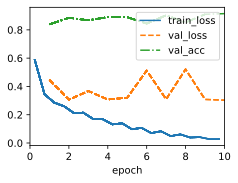

In [ ]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## ResNeXt
:label:`subsec_resnext`

One of the challenges one encounters in the design of ResNet is the trade-off between nonlinearity and dimensionality within a given block. That is, we could add more nonlinearity by increasing the number of layers, or by increasing the width of the convolutions. An alternative strategy is to increase the number of channels that can carry information between blocks. Unfortunately, the latter comes with a quadratic penalty since the computational cost of ingesting $c_\textrm{i}$ channels and emitting $c_\textrm{o}$ channels is proportional to $\mathcal{O}(c_\textrm{i} \cdot c_\textrm{o})$ (see our discussion in :numref:`sec_channels`).

We can take some inspiration from the Inception block of :numref:`fig_inception` which has information flowing through the block in separate groups. Applying the idea of multiple independent groups to the ResNet block of :numref:`fig_resnet_block` led to the design of ResNeXt :cite:`Xie.Girshick.Dollar.ea.2017`.
Different from the smorgasbord of transformations in Inception,
ResNeXt adopts the *same* transformation in all branches,
thus minimizing the need for manual tuning of each branch.

![The ResNeXt block. The use of grouped convolution with $\mathit{g}$ groups is $\mathit{g}$ times faster than a dense convolution. It is a bottleneck residual block when the number of intermediate channels $\mathit{b}$ is less than $\mathit{c}$.](../img/resnext-block.svg)
:label:`fig_resnext_block`

Breaking up a convolution from $c_\textrm{i}$ to $c_\textrm{o}$ channels into one of $g$ groups of size $c_\textrm{i}/g$ generating $g$ outputs of size $c_\textrm{o}/g$ is called, quite fittingly, a *grouped convolution*. The computational cost (proportionally) is reduced from $\mathcal{O}(c_\textrm{i} \cdot c_\textrm{o})$ to $\mathcal{O}(g \cdot (c_\textrm{i}/g) \cdot (c_\textrm{o}/g)) = \mathcal{O}(c_\textrm{i} \cdot c_\textrm{o} / g)$, i.e., it is $g$ times faster. Even better, the number of parameters needed to generate the output is also reduced from a $c_\textrm{i} \times c_\textrm{o}$ matrix to $g$ smaller matrices of size $(c_\textrm{i}/g) \times (c_\textrm{o}/g)$, again a $g$ times reduction. In what follows we assume that both $c_\textrm{i}$ and $c_\textrm{o}$ are divisible by $g$.

The only challenge in this design is that no information is exchanged between the $g$ groups. The ResNeXt block of
:numref:`fig_resnext_block` amends this in two ways: the grouped convolution with a $3 \times 3$ kernel is sandwiched in between two $1 \times 1$ convolutions. The second one serves double duty in changing the number of channels back. The benefit is that we only pay the $\mathcal{O}(c \cdot b)$ cost for $1 \times 1$ kernels and can make do with an $\mathcal{O}(b^2 / g)$ cost for $3 \times 3$ kernels. Similar to the residual block implementation in
:numref:`subsec_residual-blks`, the residual connection is replaced (thus generalized) by a $1 \times 1$ convolution.

The right-hand figure in :numref:`fig_resnext_block` provides a much more concise summary of the resulting network block. It will also play a major role in the design of generic modern CNNs in :numref:`sec_cnn-design`. Note that the idea of grouped convolutions dates back to the implementation of AlexNet :cite:`Krizhevsky.Sutskever.Hinton.2012`. When distributing the network across two GPUs with limited memory, the implementation treated each GPU as its own channel with no ill effects.

The following implementation of the `ResNeXtBlock` class takes as argument `groups` ($g$), with
`bot_channels` ($b$) intermediate (bottleneck) channels. Lastly, when we need to reduce the height and width of the representation, we add a stride of $2$ by setting `use_1x1conv=True, strides=2`.


In [ ]:
class ResNeXtBlock(nn.Module):  #@save
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

Its use is entirely analogous to that of the `ResNetBlock` discussed previously. For instance, when using (`use_1x1conv=False, strides=1`), the input and output are of the same shape. Alternatively, setting `use_1x1conv=True, strides=2` halves the output height and width.


In [ ]:
blk = ResNeXtBlock(32, 16, 1)
X = torch.randn(4, 32, 96, 96)
blk(X).shape

torch.Size([4, 32, 96, 96])

## Summary and Discussion

Nested function classes are desirable since they allow us to obtain strictly *more powerful* rather than also subtly *different* function classes when adding capacity. One way of accomplishing this is by letting additional layers to simply pass through the input to the output. Residual connections allow for this. As a consequence, this changes the inductive bias from simple functions being of the form $f(\mathbf{x}) = 0$ to simple functions looking like $f(\mathbf{x}) = \mathbf{x}$.


The residual mapping can learn the identity function more easily, such as pushing parameters in the weight layer to zero. We can train an effective *deep* neural network by having residual blocks. Inputs can forward propagate faster through the residual connections across layers. As a consequence, we can thus train much deeper networks. For instance, the original ResNet paper :cite:`He.Zhang.Ren.ea.2016` allowed for up to 152 layers. Another benefit of residual networks is that it allows us to add layers, initialized as the identity function, *during* the training process. After all, the default behavior of a layer is to let the data pass through unchanged. This can accelerate the training of very large networks in some cases.

Prior to residual connections,
bypassing paths with gating units were introduced
to effectively train highway networks with over 100 layers
:cite:`srivastava2015highway`.
Using identity functions as bypassing paths,
ResNet performed remarkably well
on multiple computer vision tasks.
Residual connections had a major influence on the design of subsequent deep neural networks, of either convolutional or sequential nature.
As we will introduce later,
the Transformer architecture :cite:`Vaswani.Shazeer.Parmar.ea.2017`
adopts residual connections (together with other design choices) and is pervasive
in areas as diverse as
language, vision, speech, and reinforcement learning.

ResNeXt is an example for how the design of convolutional neural networks has evolved over time: by being more frugal with computation and trading it off against the size of the activations (number of channels), it allows for faster and more accurate networks at lower cost. An alternative way of viewing grouped convolutions is to think of a block-diagonal matrix for the convolutional weights. Note that there are quite a few such "tricks" that lead to more efficient networks. For instance, ShiftNet :cite:`wu2018shift` mimicks the effects of a $3 \times 3$ convolution, simply by adding shifted activations to the channels, offering increased function complexity, this time without any computational cost.

A common feature of the designs we have discussed so far is that the network design is fairly manual, primarily relying on the ingenuity of the designer to find the "right" network hyperparameters. While clearly feasible, it is also very costly in terms of human time and there is no guarantee that the outcome is optimal in any sense. In :numref:`sec_cnn-design` we will discuss a number of strategies for obtaining high quality networks in a more automated fashion. In particular, we will review the notion of *network design spaces* that led to the RegNetX/Y models
:cite:`Radosavovic.Kosaraju.Girshick.ea.2020`.

## Exercises

1. What are the major differences between the Inception block in :numref:`fig_inception` and the residual block? How do they compare in terms of computation, accuracy, and the classes of functions they can describe?
1. Refer to Table 1 in the ResNet paper :cite:`He.Zhang.Ren.ea.2016` to implement different variants of the network.
1. For deeper networks, ResNet introduces a "bottleneck" architecture to reduce model complexity. Try to implement it.
1. In subsequent versions of ResNet, the authors changed the "convolution, batch normalization, and activation" structure to the "batch normalization, activation, and convolution" structure. Make this improvement yourself. See Figure 1 in :citet:`He.Zhang.Ren.ea.2016*1` for details.
1. Why can't we just increase the complexity of functions without bound, even if the function classes are nested?


## **Answer Exercise**

**1. Apa perbedaan utama antara blok Inception di :numref:`fig_inception` dan blok residual? Bagaimana perbandingannya dalam hal komputasi, akurasi, dan kelas fungsi yang bisa mereka gambarkan?**

*   Komputasi: Blok Inception lebih kompleks secara komputasi karena memiliki beberapa jalur konvolusi dengan ukuran filter yang berbeda (1x1, 3x3, 5x5), yang memerlukan lebih banyak komputasi. Blok residual, di sisi lain, lebih sederhana karena hanya menambahkan residual connection, sehingga mempercepat propagasi gradien.
*   Akurasi: Blok residual memungkinkan pelatihan jaringan yang lebih dalam secara stabil, yang mengarah pada peningkatan akurasi, terutama pada dataset yang kompleks. Inception juga meningkatkan akurasi, tetapi lebih menekankan pada menggabungkan informasi dari berbagai skala fitur.
*   Kelas Fungsi: Blok residual mampu menggambarkan fungsi identitas dengan lebih baik karena adanya shortcut connections yang memungkinkan output dari lapisan sebelumnya untuk diteruskan tanpa perubahan. Sementara Inception lebih berfokus pada ekstraksi fitur multi-skala.

**2. Rujuk Tabel 1 di makalah ResNet :cite:`He.Zhang.Ren.ea.2016` untuk mengimplementasikan berbagai varian dari jaringan tersebut.**

*   Implementasi varian ResNet dapat dimulai dengan mengatur arsitektur untuk model ResNet-18, ResNet-34, ResNet-50, dan seterusnya, mengikuti konfigurasi dari tabel 1 yang mencantumkan jumlah blok residual di setiap tahap konvolusi. Setiap model dapat diimplementasikan dengan mengubah jumlah lapisan dalam blok residual sesuai tabel tersebut.

**3. Untuk jaringan yang lebih dalam, ResNet memperkenalkan arsitektur "bottleneck" untuk mengurangi kompleksitas model. Cobalah untuk mengimplementasikannya.**

*   Arsitektur bottleneck di ResNet melibatkan penggunaan lapisan 1x1 konvolusi untuk mengurangi dimensi kanal sebelum konvolusi 3x3, lalu mengembalikan dimensi kanal dengan konvolusi 1x1 berikutnya. Ini mengurangi jumlah komputasi tanpa mengorbankan representasi fitur. Implementasi ini dapat dilakukan dengan menambahkan dua lapisan konvolusi 1x1 di sekitar konvolusi 3x3 di blok residual.

**4. Dalam versi ResNet berikutnya, penulis mengubah struktur "convolution, batch normalization, and activation" menjadi "batch normalization, activation, and convolution". Lakukan peningkatan ini sendiri. Lihat Gambar 1 di :citet:`He.Zhang.Ren.ea.2016*1` untuk detailnya.**

* Untuk meningkatkan arsitektur, urutan batch normalization, aktivasi (ReLU), dan konvolusi perlu diubah. Langkah ini melibatkan penerapan batch normalization dan ReLU sebelum konvolusi di setiap blok residual, bukan setelahnya. Ini dapat diimplementasikan dengan memodifikasi urutan layer di setiap blok residual.

**5. Mengapa kita tidak bisa terus-menerus meningkatkan kompleksitas fungsi tanpa batas, bahkan jika kelas fungsi tersebut bersarang?**

* Meskipun kelas fungsi bersarang memungkinkan kita menambah kapasitas model, kompleksitas yang berlebihan dapat menyebabkan masalah overfitting. Model yang terlalu kompleks akan belajar pola yang tidak relevan dari data pelatihan, sehingga tidak mampu melakukan generalisasi dengan baik pada data yang tidak terlihat. Selain itu, peningkatan kompleksitas juga memperlambat pelatihan dan meningkatkan kebutuhan komputasi.





#8.7 Densely Connected Networks (DenseNet)
:label:`sec_densenet`

ResNet significantly changed the view of how to parametrize the functions in deep networks. *DenseNet* (dense convolutional network) is to some extent the logical extension of this :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.
DenseNet is characterized by both the connectivity pattern where
each layer connects to all the preceding layers
and the concatenation operation (rather than the addition operator in ResNet) to preserve and reuse features
from earlier layers.
To understand how to arrive at it, let's take a small detour to mathematics.


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

## From ResNet to DenseNet

Recall the Taylor expansion for functions. At the point $x = 0$ it can be written as

$$f(x) = f(0) + x \cdot \left[f'(0) + x \cdot \left[\frac{f''(0)}{2!}  + x \cdot \left[\frac{f'''(0)}{3!}  + \cdots \right]\right]\right].$$


The key point is that it decomposes a function into terms of increasingly higher order. In a similar vein, ResNet decomposes functions into

$$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).$$

That is, ResNet decomposes $f$ into a simple linear term and a more complex
nonlinear one.
What if we wanted to capture (not necessarily add) information beyond two terms?
One such solution is DenseNet :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.

![The main difference between ResNet (left) and DenseNet (right) in cross-layer connections: use of addition and use of concatenation. ](../img/densenet-block.svg)
:label:`fig_densenet_block`

As shown in :numref:`fig_densenet_block`, the key difference between ResNet and DenseNet is that in the latter case outputs are *concatenated* (denoted by $[,]$) rather than added.
As a result, we perform a mapping from $\mathbf{x}$ to its values after applying an increasingly complex sequence of functions:

$$\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right)\right]\right), f_3\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right), f_2\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right)\right]\right)\right]\right), \ldots\right].$$

In the end, all these functions are combined in MLP to reduce the number of features again. In terms of implementation this is quite simple:
rather than adding terms, we concatenate them. The name DenseNet arises from the fact that the dependency graph between variables becomes quite dense. The final layer of such a chain is densely connected to all previous layers. The dense connections are shown in :numref:`fig_densenet`.

![Dense connections in DenseNet. Note how the dimensionality increases with depth.](http://d2l.ai/_images/densenet.svg)
:label:`fig_densenet`

The main components that comprise a DenseNet are *dense blocks* and *transition layers*. The former define how the inputs and outputs are concatenated, while the latter control the number of channels so that it is not too large,
since the expansion $\mathbf{x} \to \left[\mathbf{x}, f_1(\mathbf{x}),
f_2\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right)\right]\right), \ldots \right]$ can be quite high-dimensional.


## [**Dense Blocks**]

DenseNet uses the modified "batch normalization, activation, and convolution"
structure of ResNet (see the exercise in :numref:`sec_resnet`).
First, we implement this convolution block structure.


In [ ]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

A *dense block* consists of multiple convolution blocks, each using the same number of output channels. In the forward propagation, however, we concatenate the input and output of each convolution block on the channel dimension. Lazy evaluation allows us to adjust the dimensionality automatically.


In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

In the following example,
we [**define a `DenseBlock` instance**] with two convolution blocks of 10 output channels.
When using an input with three channels, we will get an output with  $3 + 10 + 10=23$ channels. The number of convolution block channels controls the growth in the number of output channels relative to the number of input channels. This is also referred to as the *growth rate*.


In [ ]:
blk = DenseBlock(2, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

## [**Transition Layers**]

Since each dense block will increase the number of channels, adding too many of them will lead to an excessively complex model. A *transition layer* is used to control the complexity of the model. It reduces the number of channels by using a $1\times 1$ convolution. Moreover, it halves the height and width via average pooling with a stride of 2.


In [ ]:
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

[**Apply a transition layer**] with 10 channels to the output of the dense block in the previous example.  This reduces the number of output channels to 10, and halves the height and width.


In [ ]:
blk = transition_block(10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## [**DenseNet Model**]

Next, we will construct a DenseNet model. DenseNet first uses the same single convolutional layer and max-pooling layer as in ResNet.


In [ ]:
class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

Then, similar to the four modules made up of residual blocks that ResNet uses,
DenseNet uses four dense blocks.
As with ResNet, we can set the number of convolutional layers used in each dense block. Here, we set it to 4, consistent with the ResNet-18 model in :numref:`sec_resnet`. Furthermore, we set the number of channels (i.e., growth rate) for the convolutional layers in the dense block to 32, so 128 channels will be added to each dense block.

In ResNet, the height and width are reduced between each module by a residual block with a stride of 2. Here, we use the transition layer to halve the height and width and halve the number of channels. Similar to ResNet, a global pooling layer and a fully connected layer are connected at the end to produce the output.


In [ ]:
@d2l.add_to_class(DenseNet)
def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                          growth_rate))
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(
                num_channels))
    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

## [**Training**]

Since we are using a deeper network here, in this section, we will reduce the input height and width from 224 to 96 to simplify the computation.


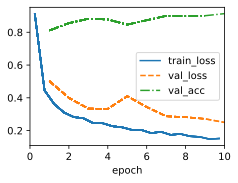

In [ ]:
model = DenseNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

## Summary and Discussion

The main components that comprise DenseNet are dense blocks and transition layers. For the latter, we need to keep the dimensionality under control when composing the network by adding transition layers that shrink the number of channels again.
In terms of cross-layer connections, in contrast to ResNet, where inputs and outputs are added together, DenseNet concatenates inputs and outputs on the channel dimension.
Although these concatenation operations
reuse features to achieve computational efficiency,
unfortunately they lead to heavy GPU memory consumption.
As a result,
applying DenseNet may require more memory-efficient implementations that may increase training time :cite:`pleiss2017memory`.


## Exercises

1. Why do we use average pooling rather than max-pooling in the transition layer?
2. One of the advantages mentioned in the DenseNet paper is that its model parameters are smaller than those of ResNet. Why is this the case?
3. One problem for which DenseNet has been criticized is its high memory consumption.
    1. Is this really the case? Try to change the input shape to $224\times 224$ to compare the actual GPU memory consumption empirically.
    2. Can you think of an alternative means of reducing the memory consumption? How would you need to change the framework?
4. Implement the various DenseNet versions presented in Table 1 of the DenseNet paper :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.
5. Design an MLP-based model by applying the DenseNet idea. Apply it to the housing price prediction task in :numref:`sec_kaggle_house`.


## **Answer Exercise**

**1. Mengapa kita menggunakan average pooling daripada max-pooling di transition layer?**

*   *Average pooling* digunakan di transition layer DenseNet untuk secara halus mengurangi dimensi fitur dan menjaga informasi global, karena average pooling mempertimbangkan kontribusi semua nilai dalam jendela pool. Sebaliknya, *max-pooling* hanya mempertahankan nilai maksimum, yang bisa menyebabkan hilangnya informasi yang lebih besar dalam jaringan yang sangat dalam seperti DenseNet, di mana setiap fitur berperan penting.

**2. Salah satu keunggulan yang disebutkan dalam makalah DenseNet adalah bahwa parameter modelnya lebih kecil daripada ResNet. Mengapa demikian?**

*   Parameter DenseNet lebih kecil karena koneksi antar lapisan dalam DenseNet dilakukan dengan penggabungan (*concatenation*) daripada penjumlahan seperti di ResNet. Hal ini memungkinkan setiap lapisan menggunakan kembali semua fitur dari lapisan sebelumnya tanpa perlu menambahkan lebih banyak parameter baru di setiap lapisan. Dengan kata lain, DenseNet lebih efisien dalam menggunakan parameter dengan menghindari penambahan bobot baru untuk setiap koneksi residual.

**3.  Salah satu masalah yang dikritik dari DenseNet adalah konsumsi memorinya yang tinggi.**

1. Apakah ini benar-benar masalah? Cobalah untuk mengubah bentuk input menjadi $224\times 224$ untuk membandingkan konsumsi memori GPU secara empiris.

  * Ya, konsumsi memori yang tinggi adalah masalah nyata di DenseNet, terutama pada resolusi input yang lebih besar seperti $224 \times 224$. Saat input menjadi lebih besar, concatenation dari fitur di setiap blok menyebabkan memori GPU semakin terbebani karena setiap lapisan harus menyimpan fitur dari semua lapisan sebelumnya.

2. Bisakah Anda memikirkan cara alternatif untuk mengurangi konsumsi memori? Bagaimana Anda perlu mengubah frameworknya?
  * Salah satu cara untuk mengurangi konsumsi memori adalah dengan menggunakan teknik seperti memory-efficient backpropagation yang menghitung ulang beberapa aktivasi selama pelatihan alih-alih menyimpannya di memori. Ini dapat dilakukan dengan mengubah framework agar menggunakan strategi seperti checkpointing, yang mengurangi jumlah memori yang diperlukan pada setiap iterasi tetapi mungkin meningkatkan waktu pelatihan.

**4. Implementasikan berbagai versi DenseNet yang disajikan dalam Tabel 1 makalah DenseNet :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.**

* Implementasi ini memerlukan pembuatan beberapa arsitektur DenseNet, seperti DenseNet-121, DenseNet-169, dan DenseNet-201, sesuai dengan jumlah blok dan kanal yang ditentukan dalam Tabel 1 dari makalah tersebut. Setiap versi menggunakan jumlah blok yang berbeda, yang menghasilkan perbedaan dalam jumlah lapisan dan parameter yang digunakan.

**5. Rancang model berbasis MLP dengan menerapkan ide DenseNet. Terapkan pada tugas prediksi harga rumah di :numref:`sec_kaggle_house`.**

* Untuk menerapkan ide DenseNet dalam model MLP, kita dapat menggabungkan keluaran dari setiap lapisan di MLP ke lapisan berikutnya, sama seperti DenseNet menggunakan concatenation. Setiap lapisan dalam MLP akan menerima input dari semua lapisan sebelumnya, sehingga memungkinkan model untuk menggunakan kembali fitur yang sudah dihitung. Implementasi ini dapat diuji pada tugas prediksi harga rumah dengan dataset Kaggle, dengan memodifikasi arsitektur MLP biasa menjadi model *dense-connected*.







#8.8 Designing Convolution Network Architectures
:label:`sec_cnn-design`

The previous sections have taken us on a tour of modern network design for computer vision. Common to all the work we covered was that it greatly relied on the intuition of scientists. Many of the architectures are heavily informed by human creativity and to a much lesser extent by systematic exploration of the design space that deep networks offer. Nonetheless, this *network engineering* approach has been tremendously successful.

Ever since AlexNet (:numref:`sec_alexnet`)
beat conventional computer vision models on ImageNet,
it has become popular to construct very deep networks
by stacking blocks of convolutions, all designed according to the same pattern.
In particular, $3 \times 3$ convolutions were
popularized by VGG networks (:numref:`sec_vgg`).
NiN (:numref:`sec_nin`) showed that even $1 \times 1$ convolutions could
be beneficial by adding local nonlinearities.
Moreover, NiN solved the problem of aggregating information at the head of a network
by aggregating across all locations.
GoogLeNet (:numref:`sec_googlenet`) added multiple branches of different convolution width,
combining the advantages of VGG and NiN in its Inception block.
ResNets (:numref:`sec_resnet`)
changed the inductive bias towards the identity mapping (from $f(x) = 0$). This allowed for very deep networks. Almost a decade later, the ResNet design is still popular, a testament to its design. Lastly, ResNeXt (:numref:`subsec_resnext`) added grouped convolutions, offering a better trade-off between parameters and computation. A precursor to Transformers for vision, the Squeeze-and-Excitation Networks (SENets) allow for efficient information transfer between locations
:cite:`Hu.Shen.Sun.2018`. This was accomplished by computing a per-channel global attention function.

Up to now we have omitted networks obtained via *neural architecture search* (NAS) :cite:`zoph2016neural,liu2018darts`. We chose to do so since their cost is usually enormous, relying on brute-force search, genetic algorithms, reinforcement learning, or some other form of hyperparameter optimization. Given a fixed search space,
NAS uses a search strategy to automatically select
an architecture based on the returned performance estimation.
The outcome of NAS
is a single network instance. EfficientNets are a notable outcome of this search :cite:`tan2019efficientnet`.

In the following we discuss an idea that is quite different to the quest for the *single best network*. It is computationally relatively inexpensive, it leads to scientific insights on the way, and it is quite effective in terms of the quality of outcomes. Let's review the strategy by :citet:`Radosavovic.Kosaraju.Girshick.ea.2020` to *design network design spaces*. The strategy combines the strength of manual design and NAS. It accomplishes this by operating on *distributions of networks* and optimizing the distributions in a way to obtain good performance for entire families of networks. The outcome of it are *RegNets*, specifically RegNetX and RegNetY, plus a range of guiding principles for the design of performant CNNs.


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## The AnyNet Design Space
:label:`subsec_the-anynet-design-space`

The description below closely follows the reasoning in :citet:`Radosavovic.Kosaraju.Girshick.ea.2020` with some abbreviations to make it fit in the scope of the book.
To begin, we need a template for the family of networks to explore. One of the commonalities of the designs in this chapter is that the networks consist of a *stem*, a *body* and a *head*. The stem performs initial image processing, often through convolutions with a larger window size. The body consists of multiple blocks, carrying out the bulk of the transformations needed to go from raw images to object representations. Lastly, the head converts this into the desired outputs, such as via a softmax regressor for multiclass classification.
The body, in turn, consists of multiple stages, operating on the image at decreasing resolutions. In fact, both the stem and each subsequent stage quarter the spatial resolution. Lastly, each stage consists of one or more blocks. This pattern is common to all networks, from VGG to ResNeXt. Indeed, for the design of generic AnyNet networks, :citet:`Radosavovic.Kosaraju.Girshick.ea.2020` used the ResNeXt block of :numref:`fig_resnext_block`.


![The AnyNet design space. The numbers $(\mathit{c}, \mathit{r})$ along each arrow indicate the number of channels $c$ and the resolution $\mathit{r} \times \mathit{r}$ of the images at that point. From left to right: generic network structure composed of stem, body, and head; body composed of four stages; detailed structure of a stage; two alternative structures for blocks, one without downsampling and one that halves the resolution in each dimension. Design choices include depth $\mathit{d_i}$, the number of output channels $\mathit{c_i}$, the number of groups $\mathit{g_i}$, and bottleneck ratio $\mathit{k_i}$ for any stage $\mathit{i}$.](http://d2l.ai/_images/anynet.svg)
:label:`fig_anynet_full`

Let's review the structure outlined in :numref:`fig_anynet_full` in detail. As mentioned, an AnyNet consists of a stem, body, and head. The stem takes as its input RGB images (3 channels), using a $3 \times 3$ convolution with a stride of $2$, followed by a batch norm, to halve the resolution from $r \times r$ to $r/2 \times r/2$. Moreover, it generates $c_0$ channels that serve as input to the body.

Since the network is designed to work well with ImageNet images of shape $224 \times 224 \times 3$, the body serves to reduce this to $7 \times 7 \times c_4$ through 4 stages (recall that $224 / 2^{1+4} = 7$), each with an eventual stride of $2$. Lastly, the head employs an entirely standard design via global average pooling, similar to NiN (:numref:`sec_nin`), followed by a fully connected layer to emit an $n$-dimensional vector for $n$-class classification.

Most of the relevant design decisions are inherent to the body of the network. It proceeds in stages, where each stage is composed of the same type of ResNeXt blocks as we discussed in :numref:`subsec_resnext`. The design there is again entirely generic: we begin with a block that halves the resolution by using a stride of $2$ (the rightmost in :numref:`fig_anynet_full`). To match this, the residual branch of the ResNeXt block needs to pass through a $1 \times 1$ convolution. This block is followed by a variable number of additional ResNeXt blocks that leave both resolution and the number of channels unchanged. Note that a common design practice is to add a slight bottleneck in the design of convolutional blocks.
As such, with bottleneck ratio $k_i \geq 1$ we afford some number of channels, $c_i/k_i$,  within each block for stage $i$ (as the experiments show, this is not really effective and should be skipped). Lastly, since we are dealing with ResNeXt blocks, we also need to pick the number of groups $g_i$ for grouped convolutions at stage $i$.

This seemingly generic design space provides us nonetheless with many parameters: we can set the block width (number of channels) $c_0, \ldots c_4$, the depth (number of blocks) per stage $d_1, \ldots d_4$, the bottleneck ratios $k_1, \ldots k_4$, and the group widths (numbers of groups) $g_1, \ldots g_4$.
In total this adds up to 17 parameters, resulting in an unreasonably large number of configurations that would warrant exploring. We need some tools to reduce this huge design space effectively. This is where the conceptual beauty of design spaces comes in. Before we do so, let's implement the generic design first.


In [ ]:
class AnyNet(d2l.Classifier):
    def stem(self, num_channels):
        return nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU())

Each stage consists of `depth` ResNeXt blocks,
where `num_channels` specifies the block width.
Note that the first block halves the height and width of input images.


In [ ]:
@d2l.add_to_class(AnyNet)
def stage(self, depth, num_channels, groups, bot_mul):
    blk = []
    for i in range(depth):
        if i == 0:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul,
                use_1x1conv=True, strides=2))
        else:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul))
    return nn.Sequential(*blk)

Putting the network stem, body, and head together,
we complete the implementation of AnyNet.


In [ ]:
@d2l.add_to_class(AnyNet)
def __init__(self, arch, stem_channels, lr=0.1, num_classes=10):
    super(AnyNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.stem(stem_channels))
    for i, s in enumerate(arch):
        self.net.add_module(f'stage{i+1}', self.stage(*s))
    self.net.add_module('head', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

## Distributions and Parameters of Design Spaces

As just discussed in :numref:`subsec_the-anynet-design-space`, parameters of a design space are hyperparameters of networks in that design space.
Consider the problem of identifying good parameters in the AnyNet design space. We could try finding the *single best* parameter choice for a given amount of computation (e.g., FLOPs and compute time). If we allowed for even only *two* possible choices for each parameter, we would have to explore $2^{17} = 131072$ combinations to find the best solution. This is clearly infeasible because of its exorbitant cost. Even worse, we do not really learn anything from this exercise in terms of how one should design a network. Next time we add, say, an X-stage, or a shift operation, or similar, we would need to start from scratch. Even worse, due to the stochasticity in training (rounding, shuffling, bit errors), no two runs are likely to produce exactly the same results. A better strategy would be to try to determine general guidelines of how the choices of parameters should be related. For instance, the bottleneck ratio, the number of channels, blocks, groups, or their change between layers should ideally be governed by a collection of simple rules. The approach in :citet:`radosavovic2019network` relies on the following four assumptions:

1. We assume that general design principles actually exist, so that many networks satisfying these requirements should offer good performance. Consequently, identifying a *distribution* over networks can be a sensible strategy. In other words, we assume that there are many good needles in the haystack.
1. We need not train networks to convergence before we can assess whether a network is good. Instead, it is sufficient to use the intermediate results as reliable guidance for final accuracy. Using (approximate) proxies to optimize an objective is referred to as multi-fidelity optimization :cite:`forrester2007multi`. Consequently, design optimization is carried out, based on the accuracy achieved after only a few passes through the dataset, reducing the cost significantly.
1. Results obtained at a smaller scale (for smaller networks) generalize to larger ones. Consequently, optimization is carried out for networks that are structurally similar, but with a smaller number of blocks, fewer channels, etc. Only in the end will we need to verify that the so-found networks also offer good performance at scale.
1. Aspects of the design can be approximately factorized so that it is possible to infer their effect on the quality of the outcome somewhat independently. In other words, the optimization problem is moderately easy.

These assumptions allow us to test many networks cheaply. In particular, we can *sample* uniformly from the space of configurations and evaluate their performance. Subsequently, we can evaluate the quality of the choice of parameters by reviewing the *distribution* of error/accuracy that can be achieved with said networks. Denote by $F(e)$ the cumulative distribution function (CDF) for errors committed by networks of a given design space, drawn using probability disribution $p$. That is,

$$F(e, p) \stackrel{\textrm{def}}{=} P_{\textrm{net} \sim p} \{e(\textrm{net}) \leq e\}.$$

Our goal is now to find a distribution $p$ over *networks* such that most networks have a very low error rate and where the support of $p$ is concise. Of course, this is computationally infeasible to perform accurately. We resort to a sample of networks $\mathcal{Z} \stackrel{\textrm{def}}{=} \{\textrm{net}_1, \ldots \textrm{net}_n\}$ (with errors $e_1, \ldots, e_n$, respectively) from $p$ and use the empirical CDF $\hat{F}(e, \mathcal{Z})$ instead:

$$\hat{F}(e, \mathcal{Z}) = \frac{1}{n}\sum_{i=1}^n \mathbf{1}(e_i \leq e).$$

Whenever the CDF for one set of choices majorizes (or matches) another CDF it follows that its choice of parameters is superior (or indifferent). Accordingly
:citet:`Radosavovic.Kosaraju.Girshick.ea.2020` experimented with a shared network bottleneck ratio $k_i = k$ for all stages $i$ of the network. This gets rid of three of the four parameters governing the bottleneck ratio. To assess whether this (negatively) affects the performance one can draw networks from the constrained and from the unconstrained distribution and compare the corresonding CDFs. It turns out that this constraint does not affect the accuracy of the distribution of networks at all, as can be seen in the first panel of :numref:`fig_regnet-fig`.
Likewise, we could choose to pick the same group width $g_i = g$ occurring at the various stages of the network. Again, this does not affect performance, as can be seen in the second panel of :numref:`fig_regnet-fig`.
Both steps combined reduce the number of free parameters by six.

![Comparing error empirical distribution functions of design spaces. $\textrm{AnyNet}_\mathit{A}$ is the original design space; $\textrm{AnyNet}_\mathit{B}$ ties the bottleneck ratios, $\textrm{AnyNet}_\mathit{C}$ also ties group widths, $\textrm{AnyNet}_\mathit{D}$ increases the network depth across stages. From left to right: (i) tying bottleneck ratios has no effect on performance; (ii) tying group widths has no effect on performance; (iii) increasing network widths (channels) across stages improves performance; (iv) increasing network depths across stages improves performance. Figure courtesy of :citet:`Radosavovic.Kosaraju.Girshick.ea.2020`.](../img/regnet-fig.png)
:label:`fig_regnet-fig`

Next we look for ways to reduce the multitude of potential choices for width and depth of the stages. It is a reasonable assumption that, as we go deeper, the number of channels should increase, i.e., $c_i \geq c_{i-1}$ ($w_{i+1} \geq w_i$ per their notation in :numref:`fig_regnet-fig`), yielding
$\textrm{AnyNetX}_D$. Likewise, it is equally reasonable to assume that as the stages progress, they should become deeper, i.e., $d_i \geq d_{i-1}$, yielding $\textrm{AnyNetX}_E$. This can be experimentally verified in the third and fourth panel of :numref:`fig_regnet-fig`, respectively.

## RegNet

The resulting $\textrm{AnyNetX}_E$ design space consists of simple networks
following easy-to-interpret design principles:

* Share the bottleneck ratio $k_i = k$ for all stages $i$;
* Share the group width $g_i = g$ for all stages $i$;
* Increase network width across stages: $c_{i} \leq c_{i+1}$;
* Increase network depth across stages: $d_{i} \leq d_{i+1}$.

This leaves us with a final set of choices: how to pick the specific values for the above parameters of the eventual $\textrm{AnyNetX}_E$ design space. By studying the best-performing networks from the distribution in $\textrm{AnyNetX}_E$ one can observe the following: the width of the network ideally increases linearly with the block index across the network, i.e., $c_j \approx c_0 + c_a j$, where $j$ is the block index and slope $c_a > 0$. Given that we get to choose a different block width only per stage, we arrive at a piecewise constant function, engineered to match this dependence. Furthermore, experiments also show that a bottleneck ratio of $k = 1$ performs best, i.e., we are advised not to use bottlenecks at all.

We recommend the interested reader reviews further details in the design of specific networks for different amounts of computation by perusing :citet:`Radosavovic.Kosaraju.Girshick.ea.2020`. For instance, an effective 32-layer RegNetX variant is given by $k = 1$ (no bottleneck), $g = 16$ (group width is 16), $c_1 = 32$ and $c_2 = 80$ channels for the first and second stage, respectively, chosen to be $d_1=4$ and $d_2=6$ blocks deep. The astonishing insight from the design is that it still applies, even when investigating networks at a larger scale. Even better, it even holds for Squeeze-and-Excitation (SE) network designs (RegNetY) that have a global channel activation :cite:`Hu.Shen.Sun.2018`.


In [ ]:
class RegNetX32(AnyNet):
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 1
        depths, channels = (4, 6), (32, 80)
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),
             (depths[1], channels[1], groups, bot_mul)),
            stem_channels, lr, num_classes)

We can see that each RegNetX stage progressively reduces resolution and increases output channels.


In [ ]:
RegNetX32().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 32, 48, 48])
Sequential output shape:	 torch.Size([1, 32, 24, 24])
Sequential output shape:	 torch.Size([1, 80, 12, 12])
Sequential output shape:	 torch.Size([1, 10])


## Training

Training the 32-layer RegNetX on the Fashion-MNIST dataset is just like before.


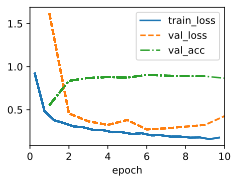

In [ ]:
model = RegNetX32(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

## Discussion

With desirable inductive biases (assumptions or preferences) like locality and translation invariance (:numref:`sec_why-conv`)
for vision, CNNs have been the dominant architectures in this area. This remained the case from LeNet up until Transformers (:numref:`sec_transformer`) :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021,touvron2021training` started surpassing CNNs in terms of accuracy. While much of the recent progress in terms of vision Transformers *can* be backported into CNNs :cite:`liu2022convnet`, it is only possible at a higher computational cost. Just as importantly, recent hardware optimizations (NVIDIA Ampere and Hopper) have only widened the gap in favor of Transformers.

It is worth noting that Transformers have a significantly lower degree of inductive bias towards locality and translation invariance than CNNs. That learned structures prevailed is due, not least, to the availability of large image collections, such as LAION-400m and LAION-5B :cite:`schuhmann2022laion` with up to 5 billion images. Quite surprisingly, some of the more relevant work in this context even includes MLPs :cite:`tolstikhin2021mlp`.

In sum, vision Transformers (:numref:`sec_vision-transformer`) by now lead in terms of
state-of-the-art performance in large-scale image classification,
showing that *scalability trumps inductive biases* :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021`.
This includes pretraining large-scale Transformers (:numref:`sec_large-pretraining-transformers`) with multi-head self-attention (:numref:`sec_multihead-attention`). We invite the readers to dive into these chapters for a much more detailed discussion.

## Exercises

1. Increase the number of stages to four. Can you design a deeper RegNetX that performs better?
2. De-ResNeXt-ify RegNets by replacing the ResNeXt block with the ResNet block. How does your new model perform?
3. Implement multiple instances of a "VioNet" family by *violating* the design principles of RegNetX. How do they perform? Which of ($d_i$, $c_i$, $g_i$, $b_i$) is the most important factor?
4. Your goal is to design the "perfect" MLP. Can you use the design principles introduced above to find good architectures? Is it possible to extrapolate from small to large networks?


## **Answer Exercise**

**1. Tingkatkan jumlah tahapan menjadi empat. Bisakah Anda merancang RegNetX yang lebih dalam dan memberikan performa yang lebih baik?**

*   Untuk meningkatkan jumlah tahapan menjadi empat, kita perlu menambah kompleksitas arsitektur RegNetX dengan menambahkan lebih banyak blok atau lapisan di setiap tahapan, sekaligus menjaga keseimbangan antara komputasi dan performa. Dengan menggunakan arsitektur yang lebih dalam, performa bisa meningkat, terutama untuk dataset yang besar dan kompleks, meskipun hal ini akan membutuhkan sumber daya komputasi yang lebih besar dan tuning parameter yang lebih cermat.

**2. Hapus elemen ResNeXt pada RegNet dengan menggantikan blok ResNeXt dengan blok ResNet. Bagaimana performa model baru Anda?**

*   Menggantikan blok ResNeXt dengan blok ResNet menghilangkan aspek *grouped convolutions* yang digunakan dalam ResNeXt. Hal ini mungkin mengurangi kemampuan model untuk menangkap informasi lokal secara efisien, karena ResNeXt memanfaatkan *grouped convolutions* untuk menangani beberapa fitur sekaligus. Namun, dengan struktur ResNet yang lebih sederhana, performa komputasi mungkin menjadi lebih ringan, meskipun akurasinya mungkin sedikit menurun dibandingkan RegNet yang menggunakan blok ResNeXt.

**3. Implementasikan beberapa contoh dari keluarga "VioNet" dengan melanggar prinsip desain RegNetX. Bagaimana performanya? Faktor mana dari ($d_i$, $c_i$, $g_i$, $b_i$) yang paling penting?**

*   Untuk membuat "VioNet", kita bisa mencoba berbagai eksperimen dengan memodifikasi faktor seperti jumlah channel ($c_i$), jumlah lapisan ($d_i$), ukuran grup ($g_i$), atau distribusi lebar blok ($b_i$). Dengan melanggar prinsip desain RegNetX, kita mungkin menemukan bahwa jumlah channel ($c_i$) dan distribusi lebar blok ($b_i$) adalah faktor yang paling penting karena mereka sangat mempengaruhi kapasitas model dan efisiensi komputasi. Sementara itu, jumlah lapisan ($d_i$) dan ukuran grup ($g_i$) mungkin juga berpengaruh, tetapi dampaknya mungkin lebih kecil pada performa keseluruhan.

**4. Tujuan Anda adalah merancang MLP yang "sempurna". Bisakah Anda menggunakan prinsip desain yang diperkenalkan di atas untuk menemukan arsitektur yang baik? Apakah mungkin untuk mengekstrapolasi dari jaringan kecil ke jaringan besar?**

* Merancang MLP yang sempurna bisa dilakukan dengan menerapkan prinsip-prinsip seperti modularitas, penggunaan fungsi aktivasi yang tepat, dan pemilihan jumlah neuron yang sesuai di setiap lapisan. Dengan menggunakan prinsip-prinsip desain dari RegNet dan Vision Transformers, kita dapat merancang MLP dengan beberapa lapisan terhubung padat dan regularisasi yang baik. Meskipun kita bisa mengekstrapolasi arsitektur dari jaringan kecil ke jaringan besar, skalabilitas mungkin menjadi tantangan, terutama dalam hal komputasi dan sumber daya memori. Ekstrapolasi ini membutuhkan pemilihan hiperparameter yang hati-hati untuk memastikan model besar tetap stabil dan efisien.

